In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [323]:
def load_results(verbose=False):
    print('loading results')
    res = {}
    architectures = ['CNN', 'MLP', 'ResNet', 'ResNet8', 'VGG']
    #architectures = ['ResNet']
    methods = ['magnitude', 'random']
    scopes = ['global', 'local']
    structures = ['structured', 'unstructured']
    structure_types = ['filter', 'kernel']
    for architecture in architectures:
        for method in methods:
            for scope in scopes:
                for structure in structures:
                    if structure == 'structured':
                        for structure_type in structure_types:
                            #res[f'{architecture}-{method}-{scope}-{structure}-{structure_type}'] = pd.read_pickle(f'./Pipelines/final-results/{architecture}-{method}-{scope}-{structure}-{structure_type}.pkl')
                            try:
                                res[f'{architecture}-{method}-{scope}-{structure}-{structure_type}'] = pd.read_pickle(f'./Pipelines/final-results/{architecture}-{method}-{scope}-{structure}-{structure_type}.pkl')
                                if verbose == True:
                                    print(f'./final-results/{architecture}-{method}-{scope}-{structure}-{structure_type}.pkl')
                            except:
                                if verbose == True:
                                    print(f'failed ./Pipelines/final-results/{architecture}-{method}-{scope}-{structure}-{structure_type}.pkl')
                                pass
                    if structure == 'unstructured':
                        try:
                            res[f'{architecture}-{method}-{scope}-{structure}'] = pd.read_pickle(f'./Pipelines/final-results/{architecture}-{method}-{scope}-{structure}.pkl')
                            if verbose == True:
                                print(f'./final-results/{architecture}-{method}-{scope}-{structure}.pkl')
                        except:

                            pass
    keys = list(res.keys())
    return res, keys
res,keys = load_results(verbose=True)

loading results
./final-results/CNN-magnitude-global-structured-filter.pkl
./final-results/CNN-magnitude-global-structured-kernel.pkl
./final-results/CNN-magnitude-global-unstructured.pkl
./final-results/CNN-magnitude-local-structured-filter.pkl
./final-results/CNN-magnitude-local-structured-kernel.pkl
./final-results/CNN-magnitude-local-unstructured.pkl
failed ./Pipelines/final-results/CNN-random-global-structured-filter.pkl
failed ./Pipelines/final-results/CNN-random-global-structured-kernel.pkl
./final-results/CNN-random-local-structured-filter.pkl
./final-results/CNN-random-local-structured-kernel.pkl
./final-results/CNN-random-local-unstructured.pkl
failed ./Pipelines/final-results/MLP-magnitude-global-structured-filter.pkl
failed ./Pipelines/final-results/MLP-magnitude-global-structured-kernel.pkl
failed ./Pipelines/final-results/MLP-magnitude-local-structured-filter.pkl
failed ./Pipelines/final-results/MLP-magnitude-local-structured-kernel.pkl
failed ./Pipelines/final-results/ML

In [324]:
keys

['CNN-magnitude-global-structured-filter',
 'CNN-magnitude-global-structured-kernel',
 'CNN-magnitude-global-unstructured',
 'CNN-magnitude-local-structured-filter',
 'CNN-magnitude-local-structured-kernel',
 'CNN-magnitude-local-unstructured',
 'CNN-random-local-structured-filter',
 'CNN-random-local-structured-kernel',
 'CNN-random-local-unstructured',
 'ResNet-magnitude-global-structured-filter',
 'ResNet-magnitude-global-structured-kernel',
 'ResNet-magnitude-global-unstructured',
 'ResNet-magnitude-local-structured-filter',
 'ResNet-magnitude-local-structured-kernel',
 'ResNet-magnitude-local-unstructured',
 'ResNet-random-local-structured-filter',
 'ResNet-random-local-structured-kernel',
 'ResNet-random-local-unstructured',
 'ResNet8-magnitude-global-structured-filter',
 'ResNet8-magnitude-global-structured-kernel',
 'ResNet8-magnitude-global-unstructured',
 'ResNet8-magnitude-local-structured-filter',
 'ResNet8-magnitude-local-structured-kernel',
 'ResNet8-magnitude-local-unstr

# Helper

In [99]:
def get_robust_lp_accuracy(col, eps = 10):
        success = []
        for i in range(len(col)):
            if (np.any([type(r)==str for r in col.tolist()])):
                success = success + [True for x in range(len(col.iloc[i][0]))]
            else:
                if type(col.iloc[i]) == float:
                    print(col.iloc[i])
                success = success + [c < eps for c in col.iloc[i][0]]
        return (1 - sum(success)/len(success))
def get_robust_l_inf_accuracy(architecture, col, eps = 8):
    if architecture=='ResNet':
        epsilons = [0.125,0.25,0.5,1,2,4]
    if architecture!='ResNet':
        epsilons = [2,4,8,16,32]
        
    idx = epsilons.index(eps)

    try:
        return 1 - np.sum([col.iloc[i][idx] for i in range(len(col))]) / len(col)
    except:
        return 1
    

def calculacte_averages(architecture, keys, l0_eps = 12, l2_eps=2.5, l_inf_eps=2):
    avg_res = {}
    for key in (keys):
        #print(key)
        avg_res[key]= pd.DataFrame()
        method_results = res[key]
        ratios = method_results['pruning_ratio'].unique()
        for ratio in ratios:
            frac_ratio = 1/(1-ratio)
            a = method_results.loc[method_results['pruning_ratio'] == ratio]
            #print(l_inf_eps)
            temp_df = pd.DataFrame({
                "mean_accuracy": a['accuracy'].mean(), 
                "mean_l0_acc": get_robust_lp_accuracy(a['bb_l0'], eps = l0_eps),
                "mean_l2_acc" : get_robust_lp_accuracy(a['cw_l2'], eps = l2_eps),
                "mean_l_inf_acc" : get_robust_l_inf_accuracy(architecture, a['pgd_linf'], eps=l_inf_eps) #x/255
            },
            index=[frac_ratio]
            )
            avg_res[key] = avg_res[key].append(temp_df)
    return avg_res
        
    


def create_fixed_eps_dataframe(architecture=None,attack_type=None,l0_eps=12, l2_eps=2.5, l_inf_eps=2):
    res, keys = load_results()
    if architecture==None or attack_type==None:
        raise ValueError('spcify architecture, and attack type')
    avg_res = calculacte_averages(architecture, keys, l0_eps=l0_eps,l2_eps=l2_eps, l_inf_eps=l_inf_eps)
    if architecture=='ResNet8':
        method_keys = keys[18:27]
    if architecture=='ResNet':
        method_keys = keys[9:18]
    #if architecture=='MLP':
        #method_keys = keys[9:18]
    if architecture=='CNN':
        method_keys = keys[:9]
    if architecture=='VGG':
        method_keys = keys[27:]
        
    l0_accs = [avg_res[key]['mean_l0_acc'] for key in method_keys]
    l0_fixed_eps_accs = []
    l2_accs = [avg_res[key]['mean_l2_acc'] for key in method_keys]
    l2_fixed_eps_accs = []
    l_inf_accs = [avg_res[key]['mean_l_inf_acc'] for key in method_keys]
    l_inf_fixed_eps_accs = []
    for key in method_keys:
        col = avg_res[key]['mean_l0_acc']
        col = col.rename(key)
        
        l0_fixed_eps_accs.append(col)
        col = avg_res[key]['mean_l2_acc']
        col = col.rename(key)
        l2_fixed_eps_accs.append(col)
        col = avg_res[key]['mean_l_inf_acc']
        col = col.rename(key)
        l_inf_fixed_eps_accs.append(col)
    l0_fixed_eps_df = pd.concat(l0_fixed_eps_accs, axis=1, sort=False)
    l2_fixed_eps_df = pd.concat(l2_fixed_eps_accs, axis=1, sort=False)
    l_inf_fixed_eps_df = pd.concat(l_inf_fixed_eps_accs, axis=1, sort=False)
    if attack_type==None:
        return False
    if attack_type=='l0':
        return l0_fixed_eps_df
    if attack_type=='l2':
        return l2_fixed_eps_df 
    if attack_type=='l_inf':
        return l_inf_fixed_eps_df
    
def create_fixed_ratio_dataframe(architecture=None, attack_type=None):
    if architecture==None or attack_type==None:
        raise ValueError('spcify architecture, and attack type')
    avg_res = calculacte_averages(architecture, keys,)
    #if architecture=='MLP':
    #    keys = keys[9:18]
    if architecture=='CNN':
        keys = keys[:9]
    if architecture=='ResNet8':
        method_keys = keys[18:27]
    if architecture=='ResNet':
        method_keys = keys[9:18]
    if architecture=='VGG':
        method_keys = keys[27:]
    RATIO_TO_EXAMINE = 4
    epsilons = [2,4,8,16,32]

    avg_robust_accuracies = {}
    ratio_to_examine = 1 - 1 / RATIO_TO_EXAMINE
    
    for key in (keys):
        #print(key)
        method_results = res[key]
        fixed_ratio_results = method_results.loc[method_results['pruning_ratio'] == ratio_to_examine]
        #print(fixed_ratio_results)
        temp_list = []
        if attack_type == 'l_inf':
            for fixed_ratio_result in fixed_ratio_results['pgd_linf']:
                temp_list.append(fixed_ratio_result)
        if attack_type == 'l2':
            temp_list.append([get_robust_lp_accuracy(fixed_ratio_results['cw_l2'], eps = eps) for eps in epsilons])
        if attack_type == 'l0':
            temp_list.append([get_robust_lp_accuracy(fixed_ratio_results['bb_l0'], eps = eps) for eps in epsilons])
            #print('yo',get_robust_lp_accuracy(fixed_ratio_results['bb_l0'], eps = 12))
            
            
        vals_per_eps = pd.DataFrame(temp_list, columns=epsilons)
        vals_per_eps.mean(axis=0)
        if attack_type=='l_inf':
            avg_robust_accuracies[key]=(1-vals_per_eps.mean(axis=0))
        else:
            avg_robust_accuracies[key]=(vals_per_eps.mean(axis=0))
    fixed_eps_robust_accuracies = pd.DataFrame(avg_robust_accuracies)
    return fixed_eps_robust_accuracies


def plot_graphic(fixed_eps_df, fixed_ratio_df, title_1=None, title_2=None,x_axis_label_1=None, y_axis_label_1=None, x_axis_label_2=None, y_axis_label_2=None):
    fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw={'wspace': 0.05, hspace:0.5})
    axes = axes.flatten()


    x = fixed_eps_df.plot(marker='o', markersize=15,figsize=(40,10), fontsize=16, linewidth=5, ax=axes[0])
    x.set_title(title_1, fontsize=32)
    x.set_xscale('log')
    x.set_xticks([1,2,4,8,16,32,64])
    x.set_xticklabels([1,2,4,8,16,32,64] )
    x.minorticks_off()
    x.set_xlabel(x_axis_label_1, fontsize=22)
    x.set_ylabel(y_axis_label_1, fontsize=22)
    x.legend(prop={'size': 16})


    x = fixed_ratio_df.plot(marker='o', markersize=15, figsize=(40,10), fontsize=16, linewidth=5, ax=axes[1])
    x.set_xscale('log')
    x.set_xticks([2,4,8,16,32])
    
    x.set_title(title_2, fontsize=32)
    x.set_xscale('log')
    x.set_xticks([2,4,8,16,32])
    x.set_xticklabels([2,4,8,16,32] )
    x.minorticks_off()
    x.set_xlabel(x_axis_label_2, fontsize=22)
    x.set_ylabel(y_axis_label_2, fontsize=22)
    x.legend(prop={'size': 16})
    
def plot_graphic(fixed_eps_dfs=None, title=None,x_axis_label=None, y_axis_label=None, eps=None, figname=None, infty=False):
    if fixed_eps_dfs ==None or figname==None:
        raise ValueError('you need to provide dfs and figname to plot')
        
    fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.3})
    axes = axes.flatten()
    
    for i, fixed_eps_df in enumerate(fixed_eps_dfs):
        if infty == False:
            full_title = title+str(eps[i])
        if infty == True:
            full_title = title+str(eps[i]) + ' / 255'
        x = fixed_eps_df.plot(style=[':','--','-']*3, marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[i],color=['r', 'r', 'r', 'g', 'g', 'g', 'y', 'y', 'y'])
        
        x.set_title(full_title, fontsize=40)
        x.set_xscale('log')
        x.set_xticks([1,2,4,8,16,32,64])
        x.set_xticklabels([1,2,4,8,16,32,64] )
        x.minorticks_off()
        x.set_xlabel(x_axis_label, fontsize=32)
        x.set_ylabel(y_axis_label, fontsize=32)
        if i==3:
            x.legend(prop={'size': 28})
        else:
            x.get_legend().remove()
    #fig.tight_layout()
    fig.savefig(f'./graphics/{figname}.png', dpi=72, bbox_inches='tight')
    

# MLP

## $L_0$-Attack

In [6]:
local_eps = [4,8,16,32]
mlp_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='MLP', l0_eps=eps) for eps in local_eps]
#mlp_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l0', architecture='MLP')

loading results


UnboundLocalError: local variable 'method_keys' referenced before assignment

In [ ]:
plot_graphic(
    mlp_l0_fixed_eps_dfs, 
    title=fr'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=[4,8,16,32],
    figname='mlp_l0_fixed_eps'
)

## $L_2$-Attack

In [ ]:
local_eps = [1,2,3,4]
mlp_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='MLP', l2_eps=eps) for eps in local_eps]
#mlp_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='MLP')


In [ ]:
plot_graphic(
    mlp_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='mlp_l2_fixed_eps'
)



## $L_\infty$-Attack

In [ ]:
local_eps=[4,8,16,32]
mlp_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='MLP', l_inf_eps=eps) for eps in local_eps]
#mlp_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='MLP')

In [ ]:
plot_graphic(
    mlp_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='mlp_l_inf_fixed_eps',
    infty=True
)

# CNN-s

## $L_0$-Attack

In [325]:
local_eps=[3,9,12,15]
cnn_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='CNN', l0_eps=eps) for eps in local_eps]
#cnn_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='CNN')

for i,df in enumerate(cnn_l0_fixed_eps_dfs):
    cnn_l0_fixed_eps_dfs[i] = df[['CNN-magnitude-global-structured-filter', 'CNN-magnitude-local-structured-filter', 
            'CNN-random-local-structured-filter', 'CNN-magnitude-global-structured-kernel', 
            'CNN-magnitude-local-structured-kernel', 'CNN-random-local-structured-kernel', 
            'CNN-magnitude-global-unstructured', 'CNN-magnitude-local-unstructured', 
            'CNN-random-local-unstructured']]

loading results
loading results
loading results
loading results


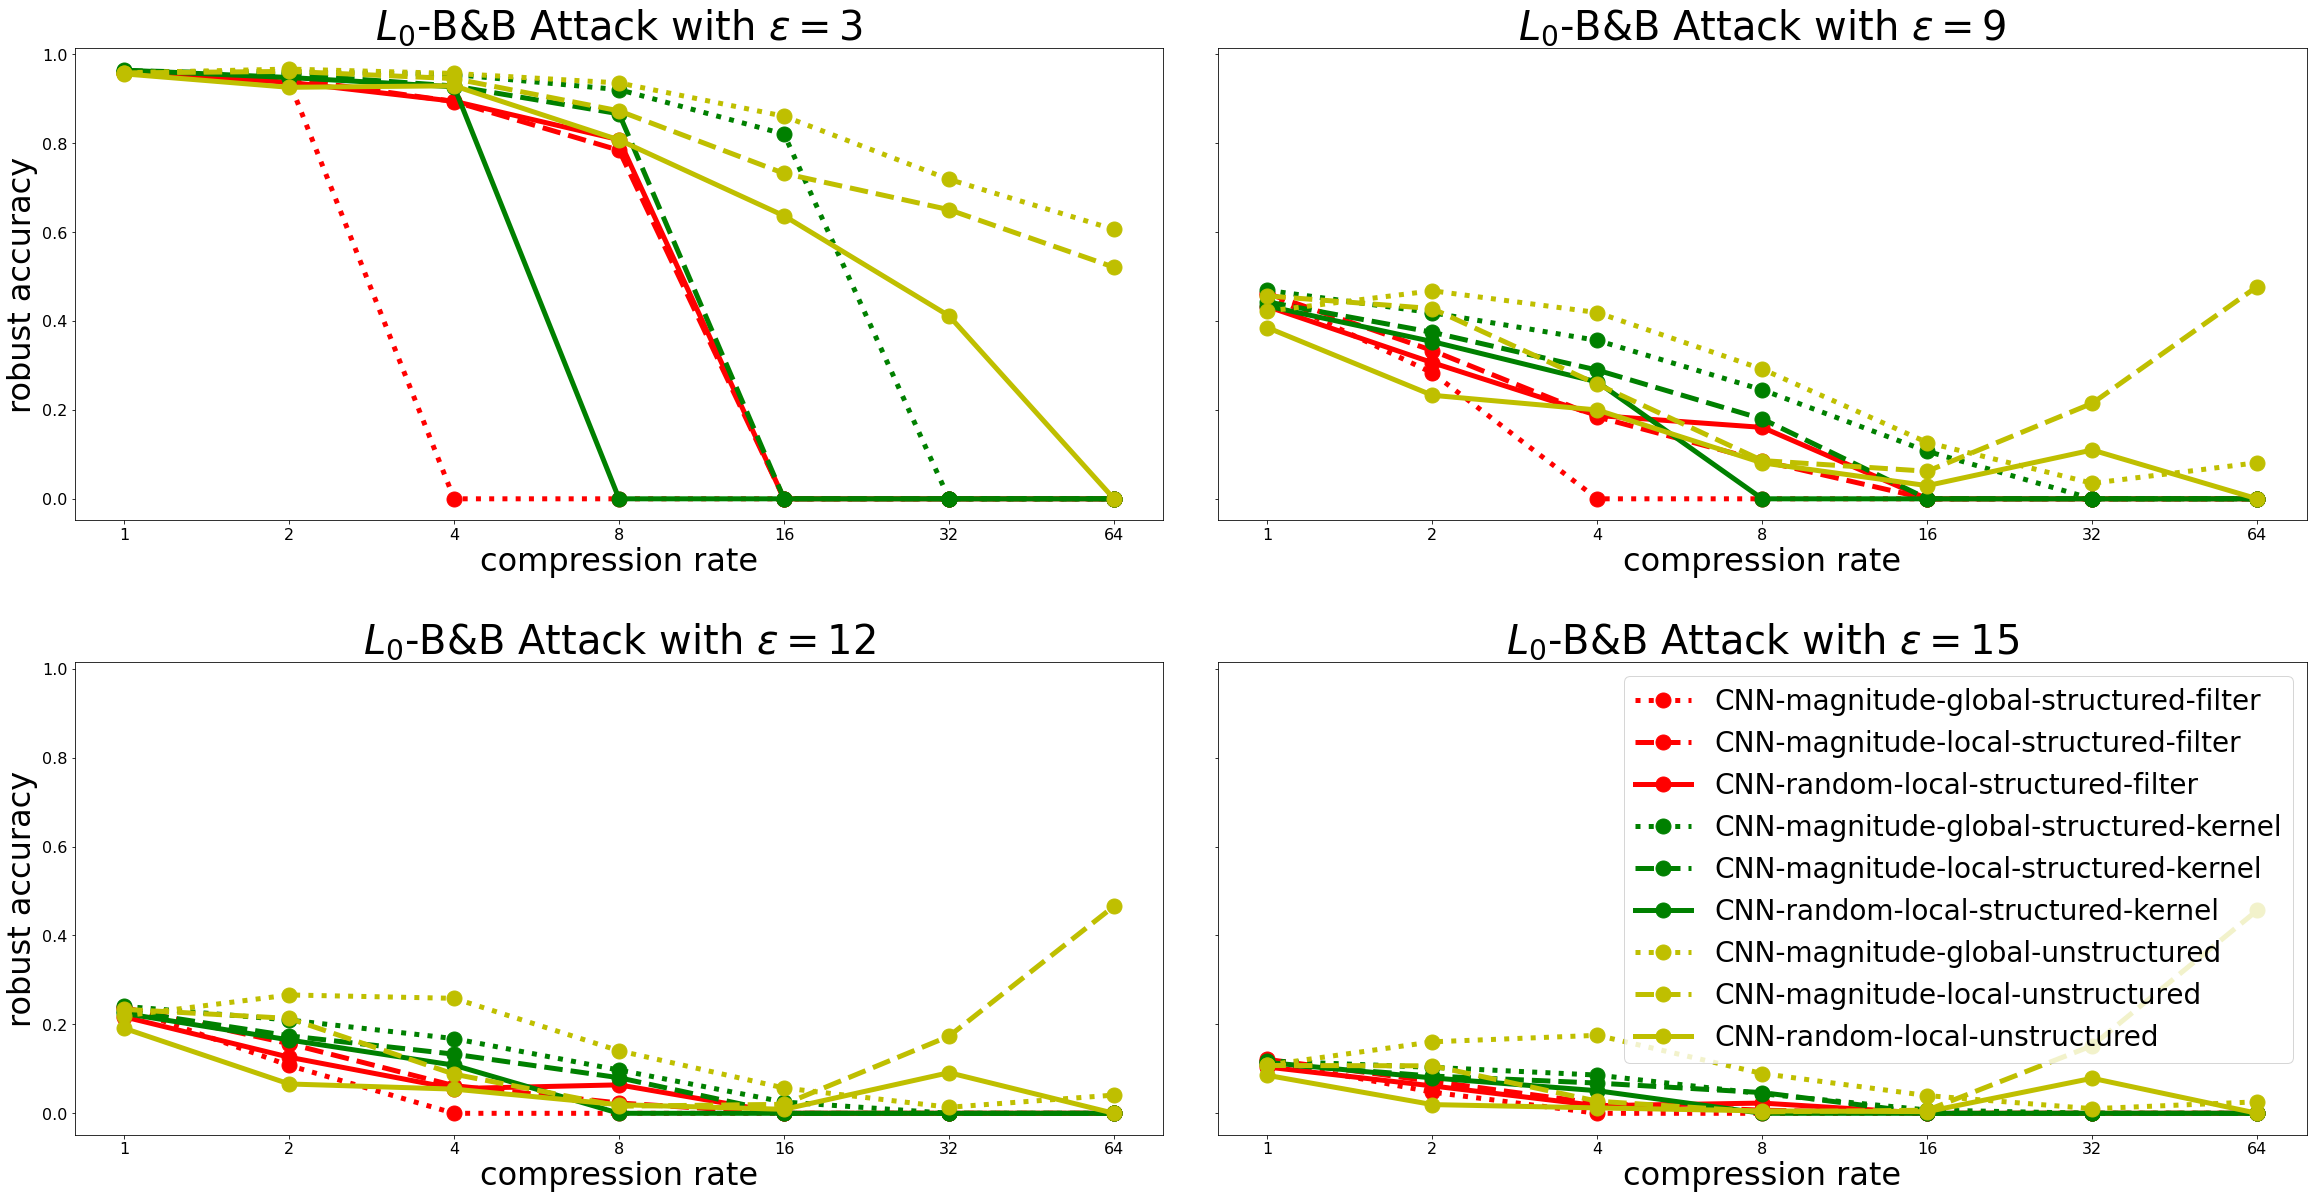

In [326]:
plot_graphic(
    cnn_l0_fixed_eps_dfs, 
    title=r'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='cnn_l0_fixed_eps'
)


## $L_2$-Attack

In [327]:
local_eps = [1,2,3,4]
cnn_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='CNN', l2_eps=eps) for eps in local_eps]
#cnn_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='CNN')
for i,df in enumerate(cnn_l2_fixed_eps_dfs):
    cnn_l2_fixed_eps_dfs[i] = df[['CNN-magnitude-global-structured-filter', 'CNN-magnitude-local-structured-filter', 
            'CNN-random-local-structured-filter', 'CNN-magnitude-global-structured-kernel', 
            'CNN-magnitude-local-structured-kernel', 'CNN-random-local-structured-kernel', 
            'CNN-magnitude-global-unstructured', 'CNN-magnitude-local-unstructured', 
            'CNN-random-local-unstructured']]

loading results
loading results
loading results
loading results


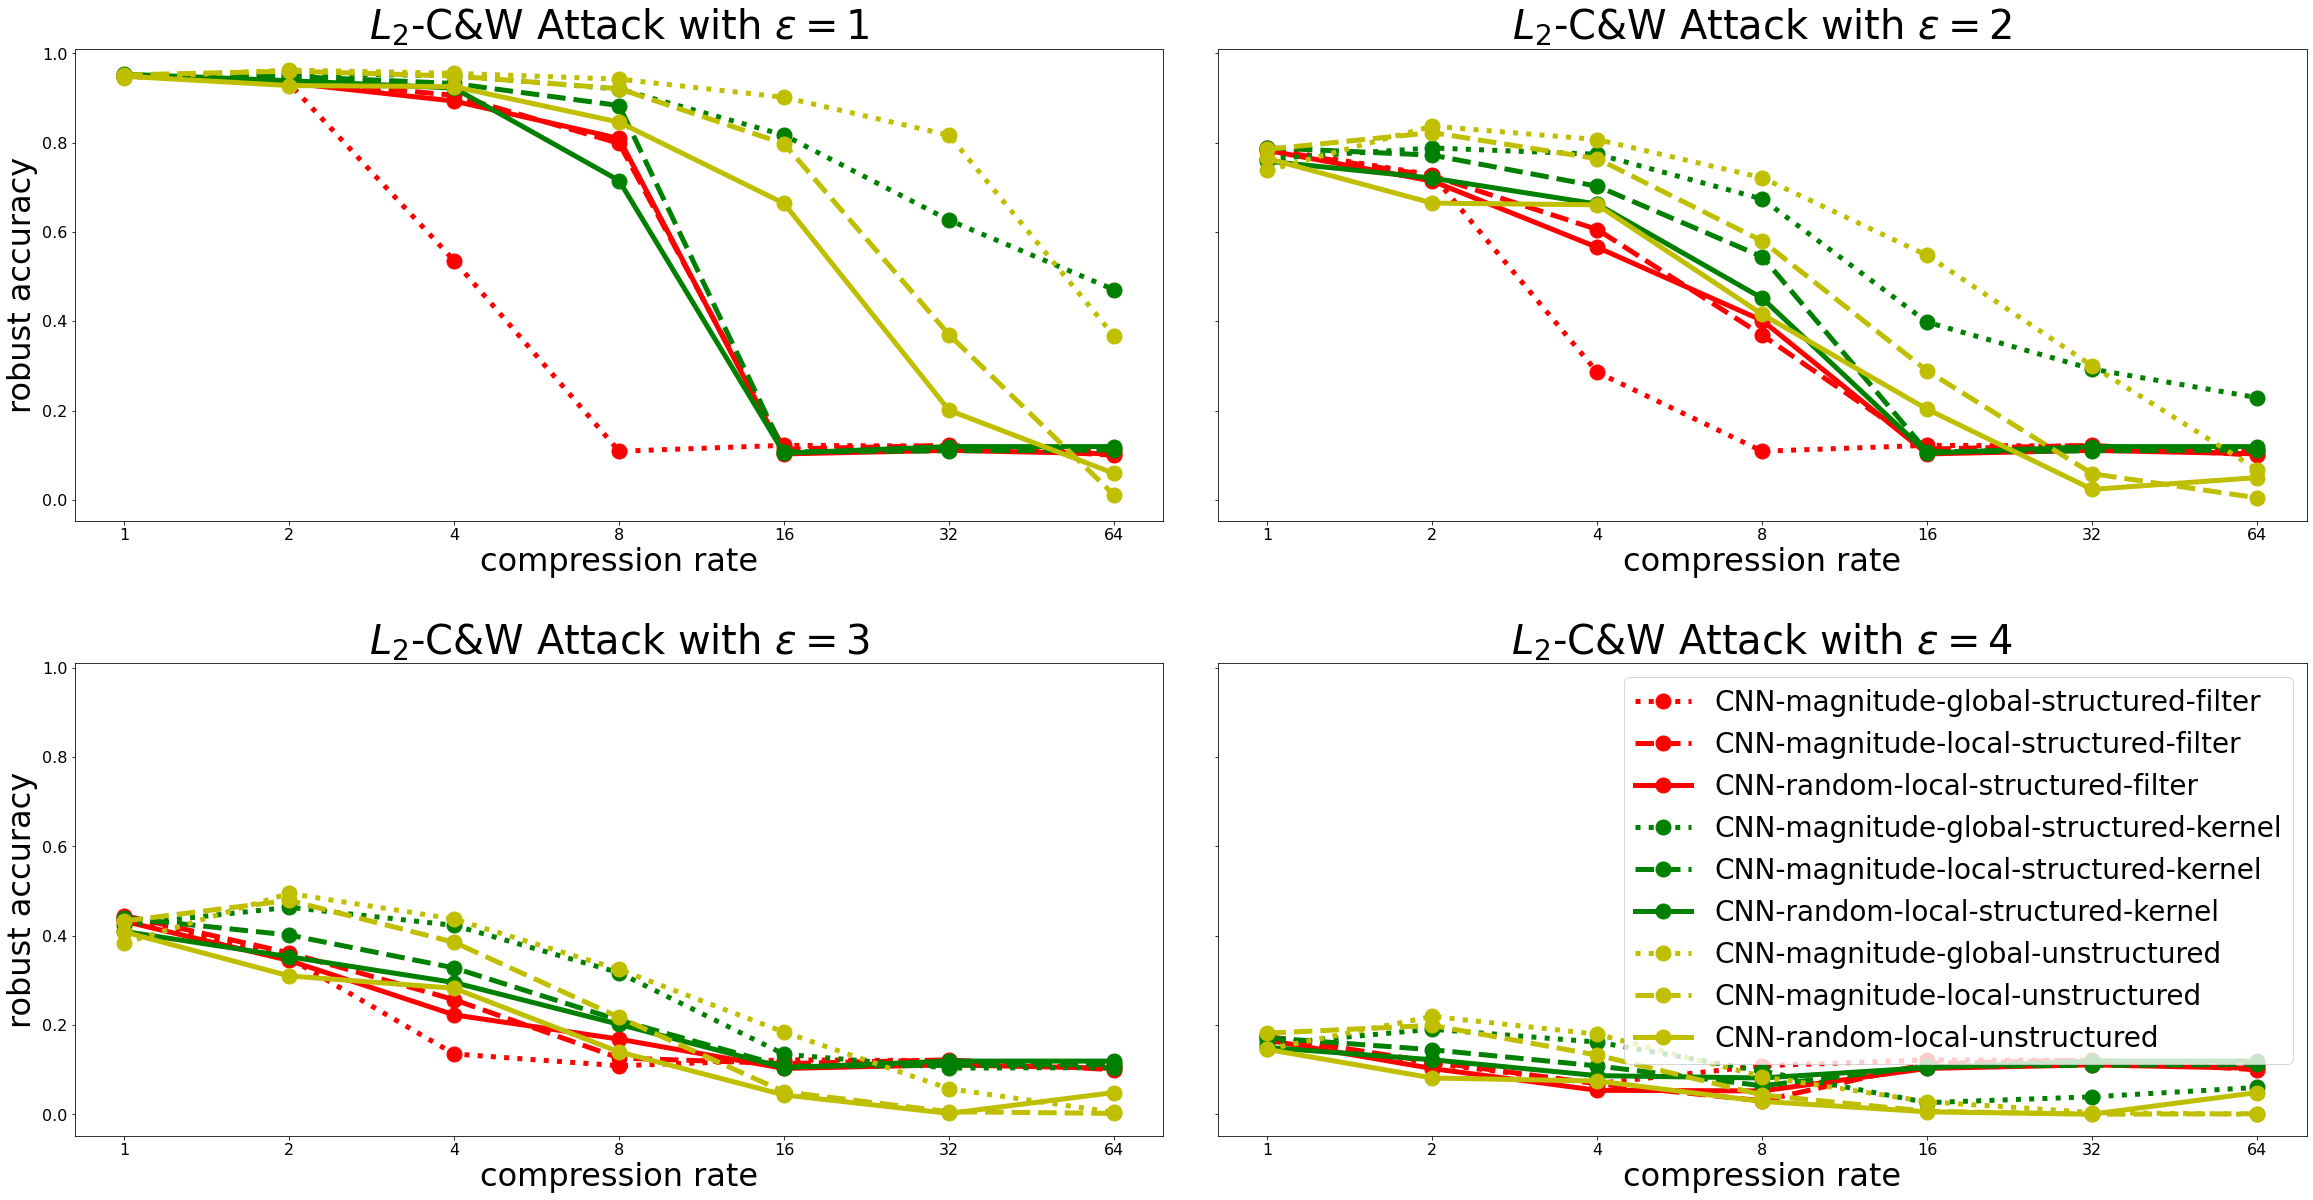

In [328]:
plot_graphic(
    cnn_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='cnn_l2_fixed_eps'
)


# $L_\infty$-Attack

In [329]:
local_eps=[2,4,8,16]
cnn_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='CNN', l_inf_eps=eps) for eps in local_eps]
#cnn_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='CNN')
for i,df in enumerate(cnn_l_inf_fixed_eps_dfs):
    cnn_l_inf_fixed_eps_dfs[i] = df[['CNN-magnitude-global-structured-filter', 'CNN-magnitude-local-structured-filter', 
            'CNN-random-local-structured-filter', 'CNN-magnitude-global-structured-kernel', 
            'CNN-magnitude-local-structured-kernel', 'CNN-random-local-structured-kernel', 
            'CNN-magnitude-global-unstructured', 'CNN-magnitude-local-unstructured', 
            'CNN-random-local-unstructured']]

loading results
loading results
loading results
loading results


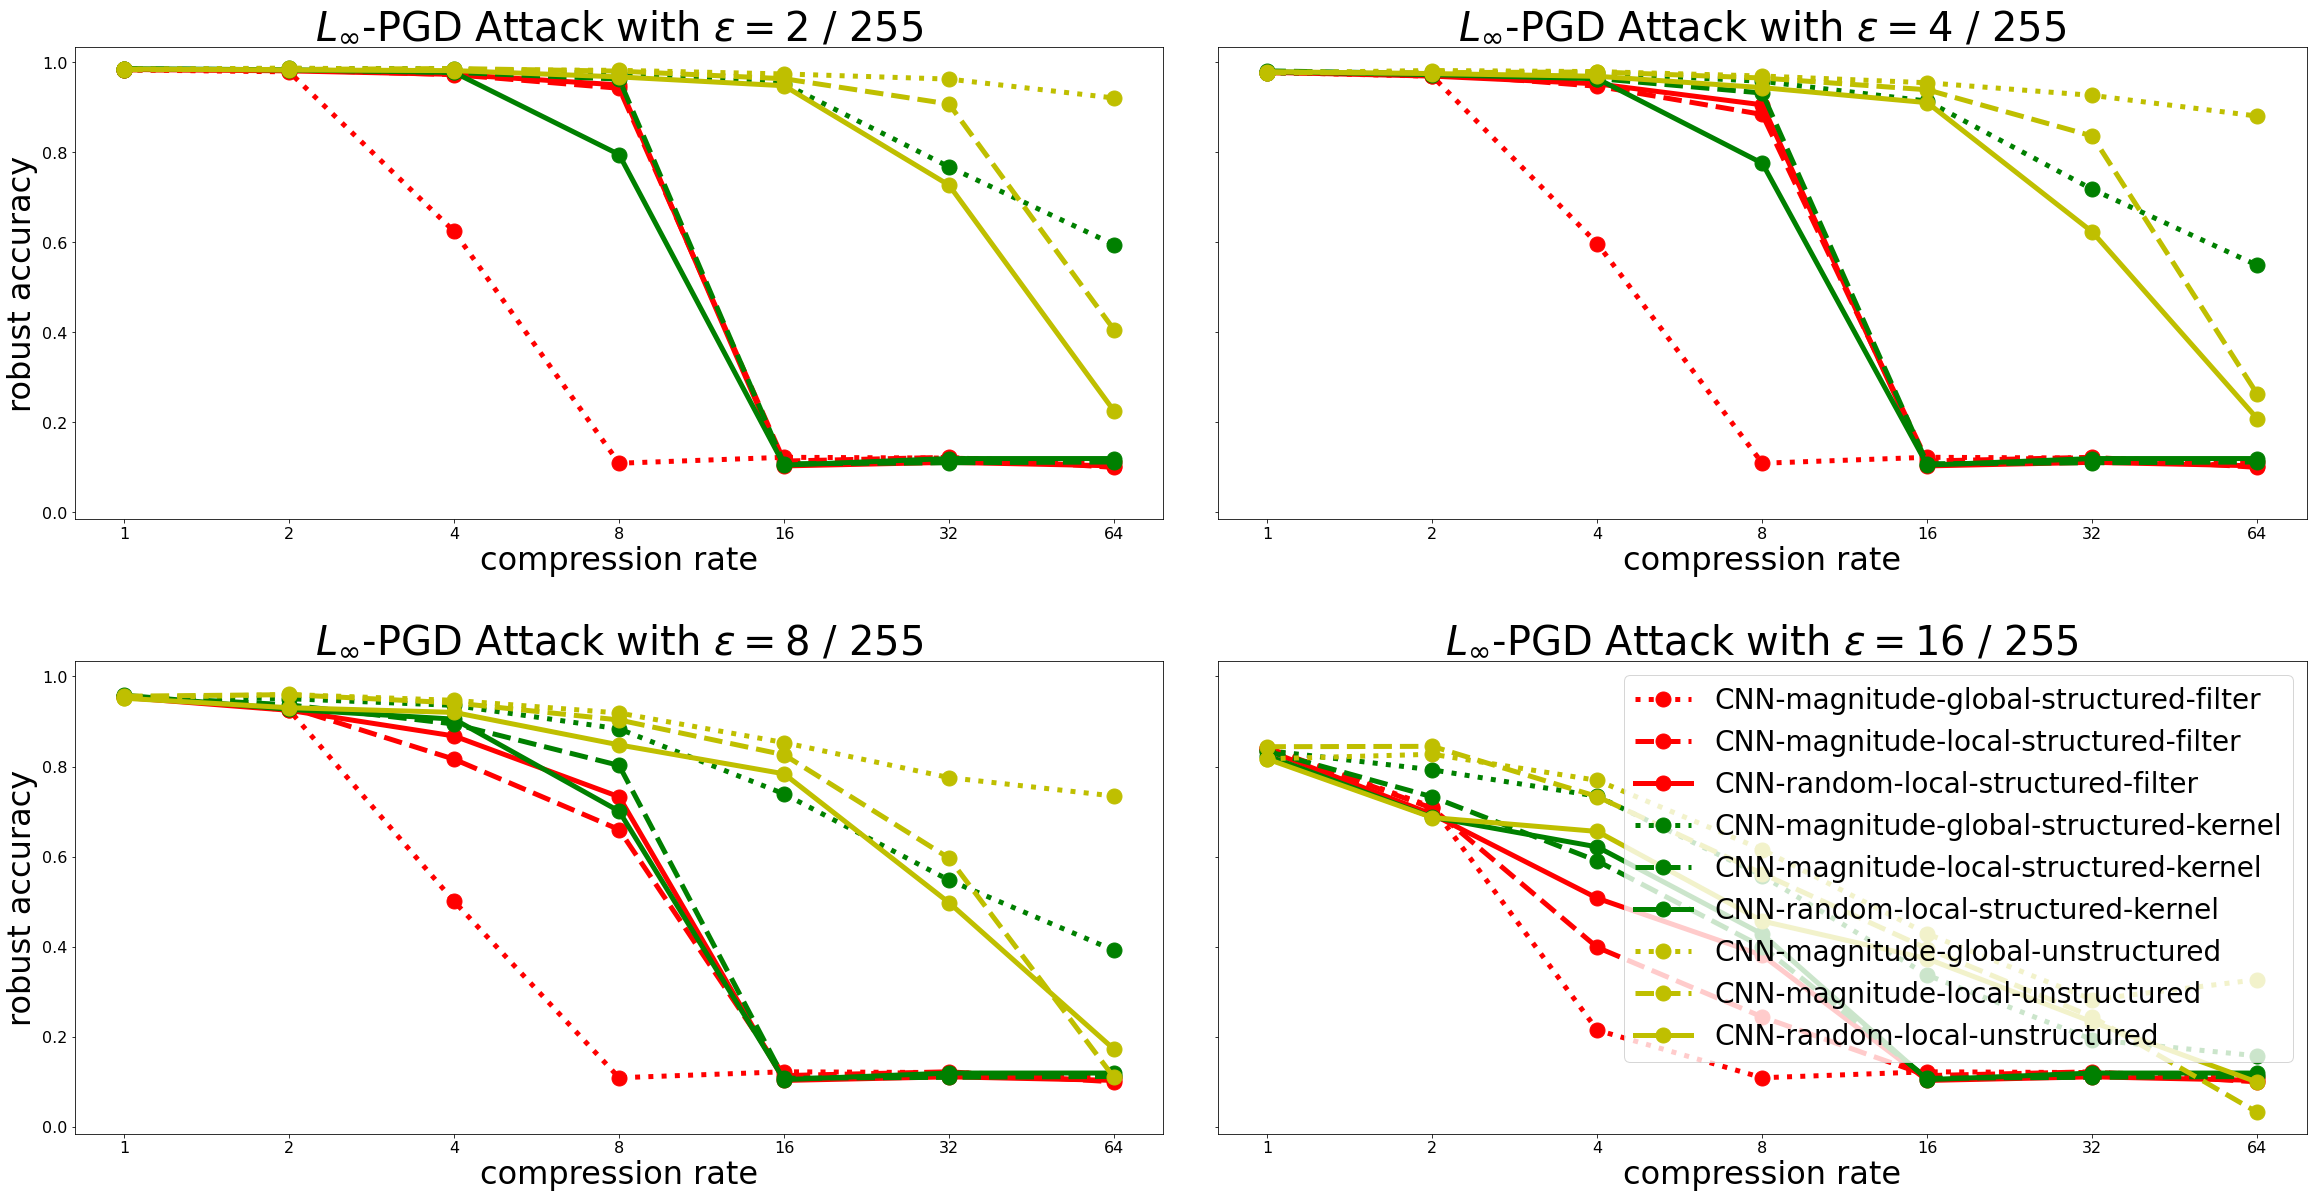

In [330]:
plot_graphic(
    cnn_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='cnn_l_inf_fixed_eps',
    infty=True
)

# ResNet8

## $L_0$-Attack

In [331]:
local_eps=[2,4,6,8]
resnet8_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='ResNet8', l0_eps=eps) for eps in local_eps]
#resnet_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

loading results
loading results
loading results
loading results


In [332]:
for i,df in enumerate(resnet8_l0_fixed_eps_dfs):
    resnet8_l0_fixed_eps_dfs[i] = df[['ResNet8-magnitude-global-structured-filter', 'ResNet8-magnitude-local-structured-filter', 
            'ResNet8-random-local-structured-filter', 'ResNet8-magnitude-global-structured-kernel', 
            'ResNet8-magnitude-local-structured-kernel', 'ResNet8-random-local-structured-kernel', 
            'ResNet8-magnitude-global-unstructured', 'ResNet8-magnitude-local-unstructured', 
            'ResNet8-random-local-unstructured']]

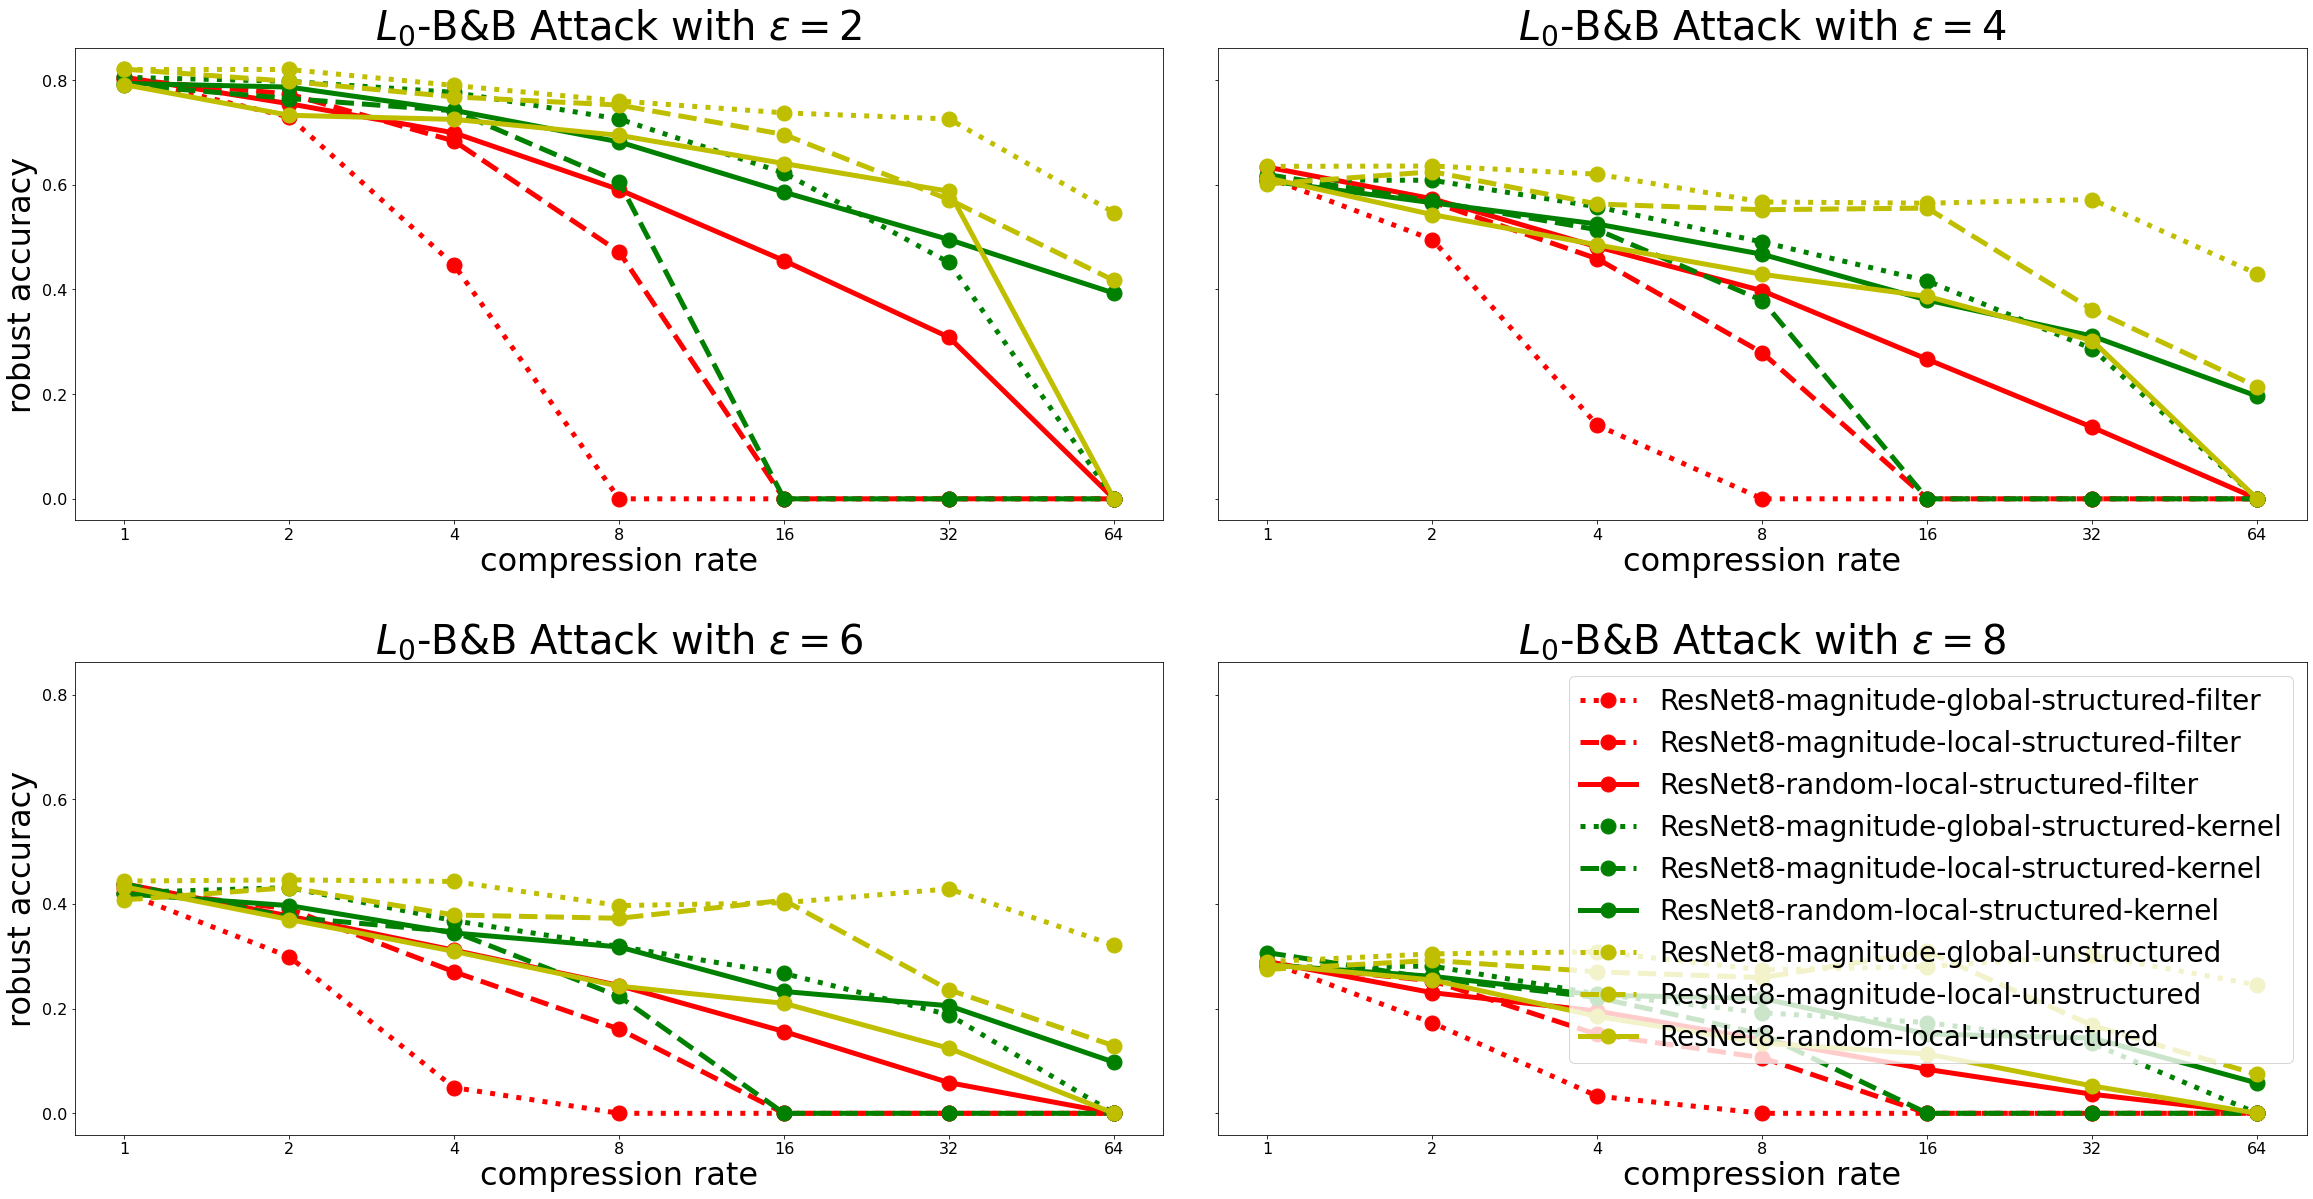

In [333]:
plot_graphic(
    resnet8_l0_fixed_eps_dfs, 
    title=r'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet8_l0_fixed_eps'
)
#cnn_l0_fixed_eps_df

## $L_2$-Attack

In [334]:
local_eps= [2,2.5,3,3.5]
resnet8_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='ResNet8', l2_eps=eps) for eps in local_eps]
#resnet_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='ResNet')

loading results
loading results
loading results
loading results


In [335]:
for i,df in enumerate(resnet8_l2_fixed_eps_dfs):
    resnet8_l2_fixed_eps_dfs[i] = df[['ResNet8-magnitude-global-structured-filter', 'ResNet8-magnitude-local-structured-filter', 
            'ResNet8-random-local-structured-filter', 'ResNet8-magnitude-global-structured-kernel', 
            'ResNet8-magnitude-local-structured-kernel', 'ResNet8-random-local-structured-kernel', 
            'ResNet8-magnitude-global-unstructured', 'ResNet8-magnitude-local-unstructured', 'ResNet8-random-local-unstructured']]

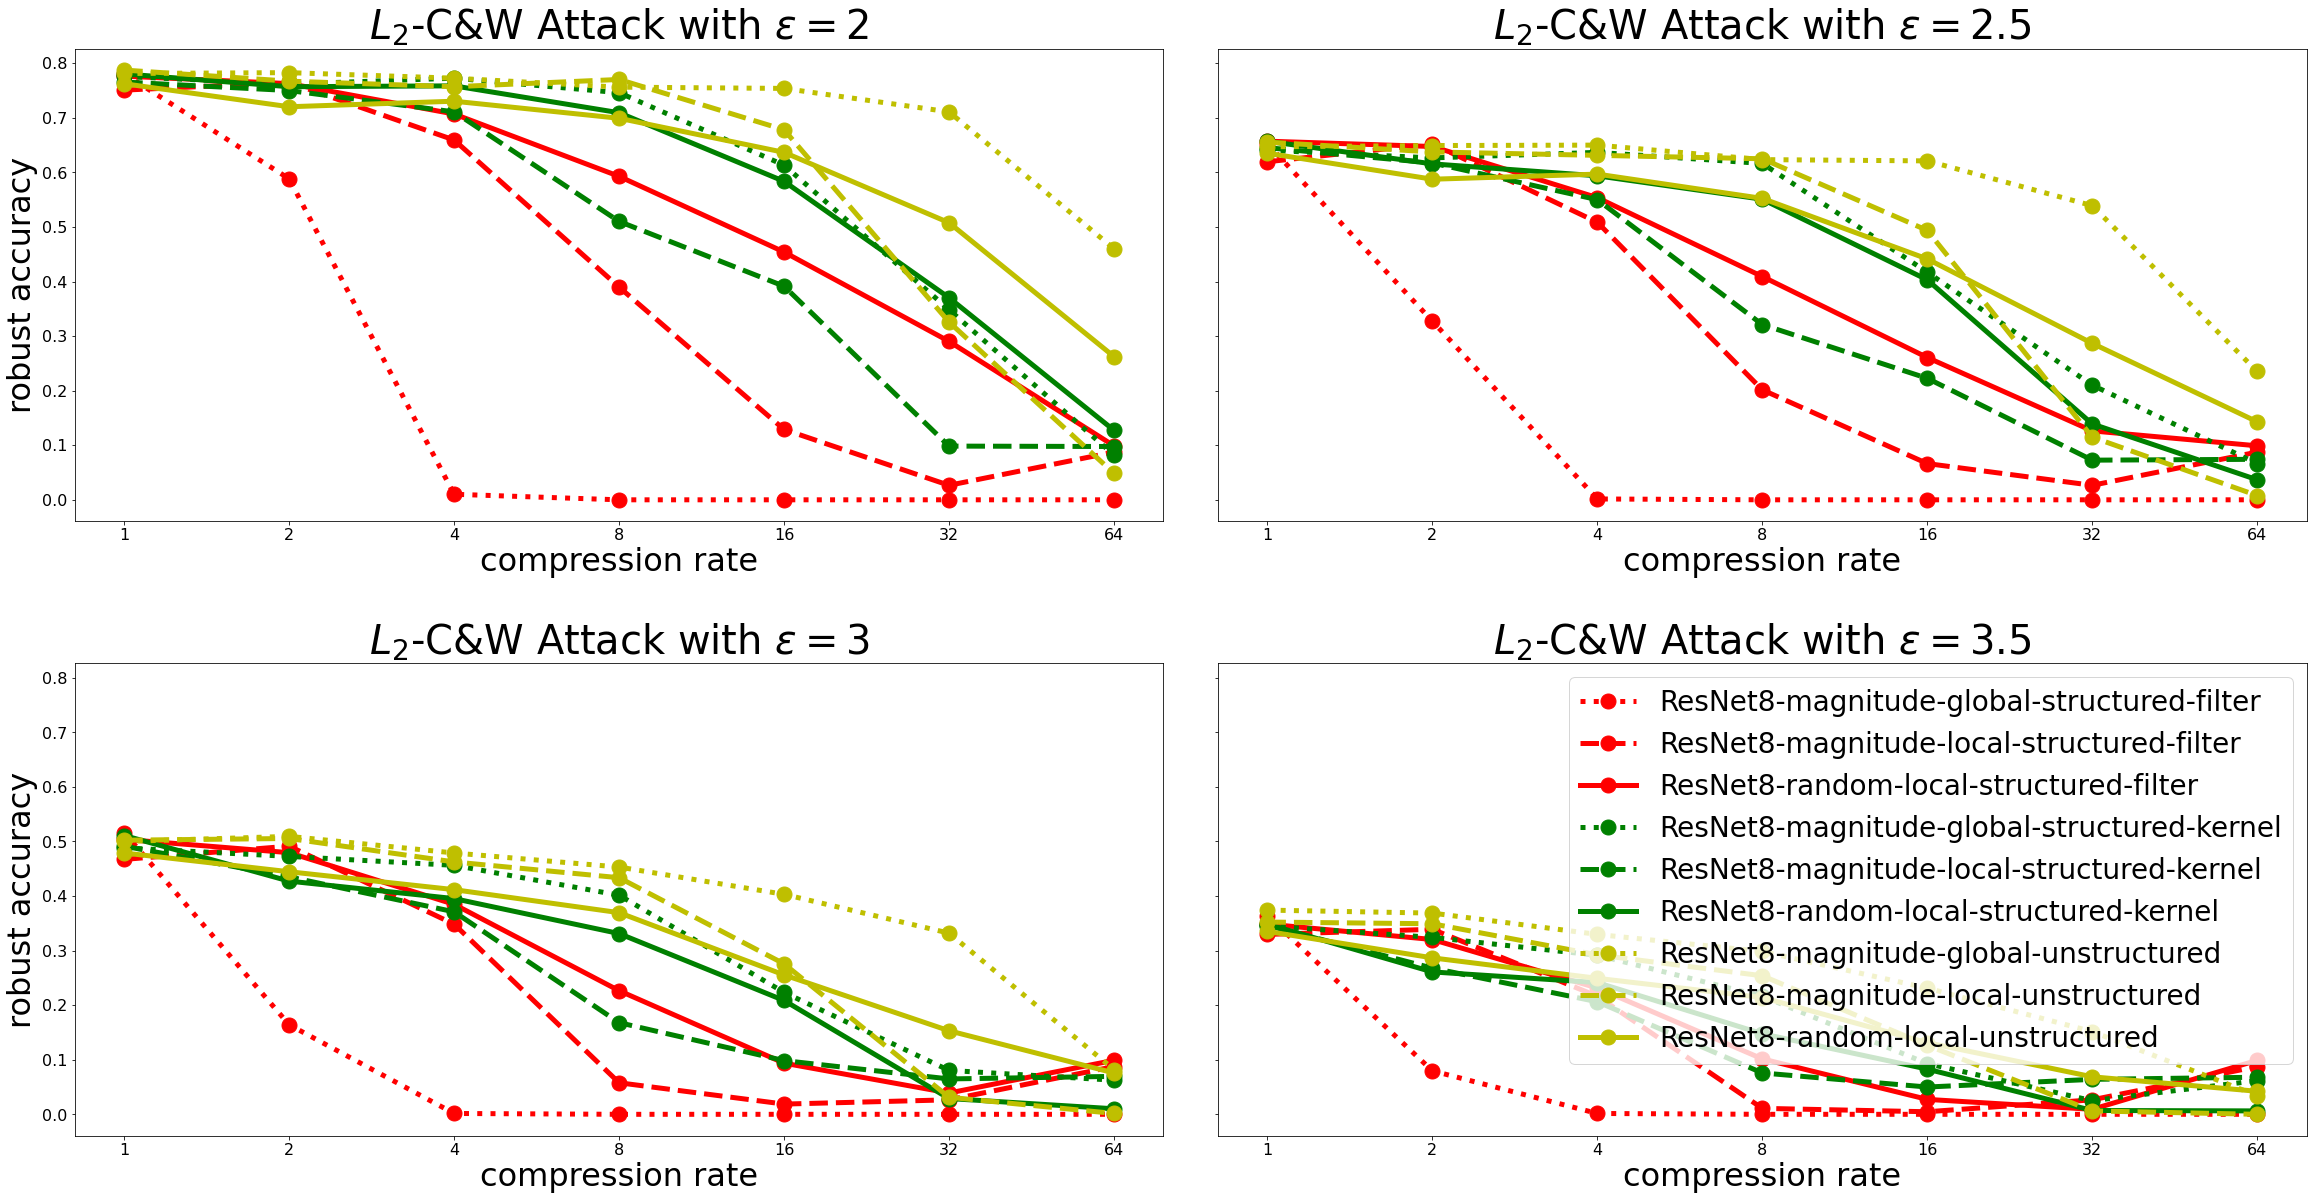

In [336]:
plot_graphic(
    resnet8_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet8_l2_fixed_eps'
)
#cnn_l2_fixed_eps_df

## $L_\infty$-Attack

In [337]:
local_eps=[2,4,8,16]
resnet8_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='ResNet8', l_inf_eps=eps) for eps in local_eps]
#resnet_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

loading results
loading results
loading results
loading results


In [338]:
for i,df in enumerate(resnet8_l_inf_fixed_eps_dfs):

    resnet8_l_inf_fixed_eps_dfs[i] = df[['ResNet8-magnitude-global-structured-filter', 'ResNet8-magnitude-local-structured-filter', 
            'ResNet8-random-local-structured-filter', 'ResNet8-magnitude-global-structured-kernel', 
            'ResNet8-magnitude-local-structured-kernel', 'ResNet8-random-local-structured-kernel', 
            'ResNet8-magnitude-global-unstructured', 'ResNet8-magnitude-local-unstructured', 
            'ResNet8-random-local-unstructured']]

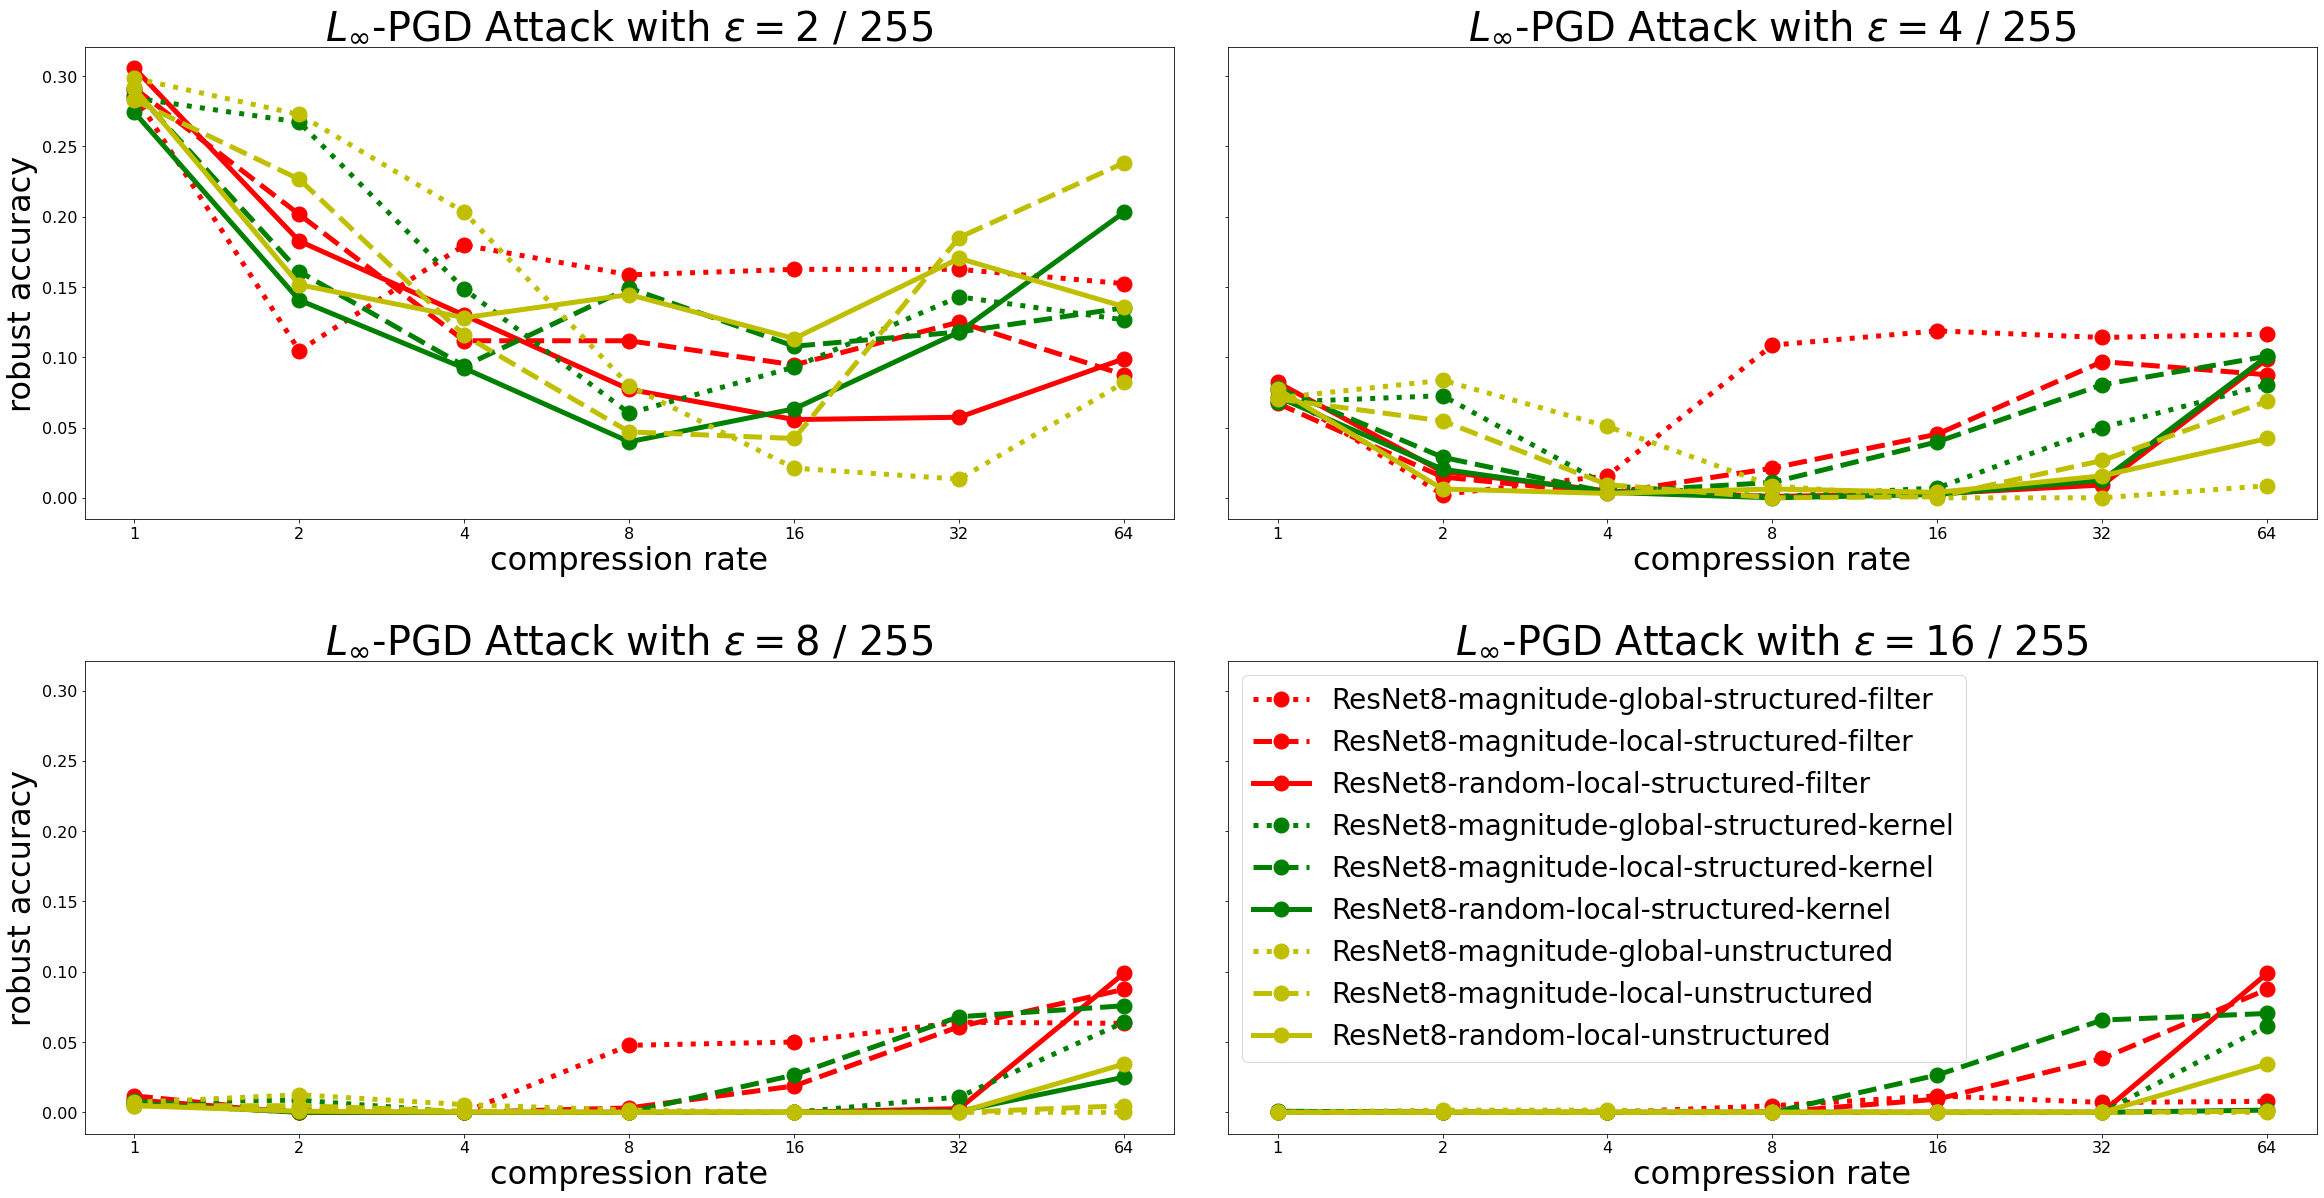

In [339]:
plot_graphic(
    resnet8_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet8_l_inf_fixed_eps',
    infty=True
)

# VGG11

## $L_0$-Attack

In [340]:
local_eps=[2,4,6,8]
VGG_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='VGG', l0_eps=eps) for eps in local_eps]
#resnet_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

loading results
loading results
loading results
loading results


In [341]:
for i,df in enumerate(VGG_l0_fixed_eps_dfs):
    VGG_l0_fixed_eps_dfs[i] = df[['VGG-magnitude-global-structured-filter', 'VGG-magnitude-local-structured-filter', 
            'VGG-random-local-structured-filter', 'VGG-magnitude-global-structured-kernel', 
            'VGG-magnitude-local-structured-kernel', 'VGG-random-local-structured-kernel', 
            'VGG-magnitude-global-unstructured', 'VGG-magnitude-local-unstructured', 
            'VGG-random-local-unstructured']]

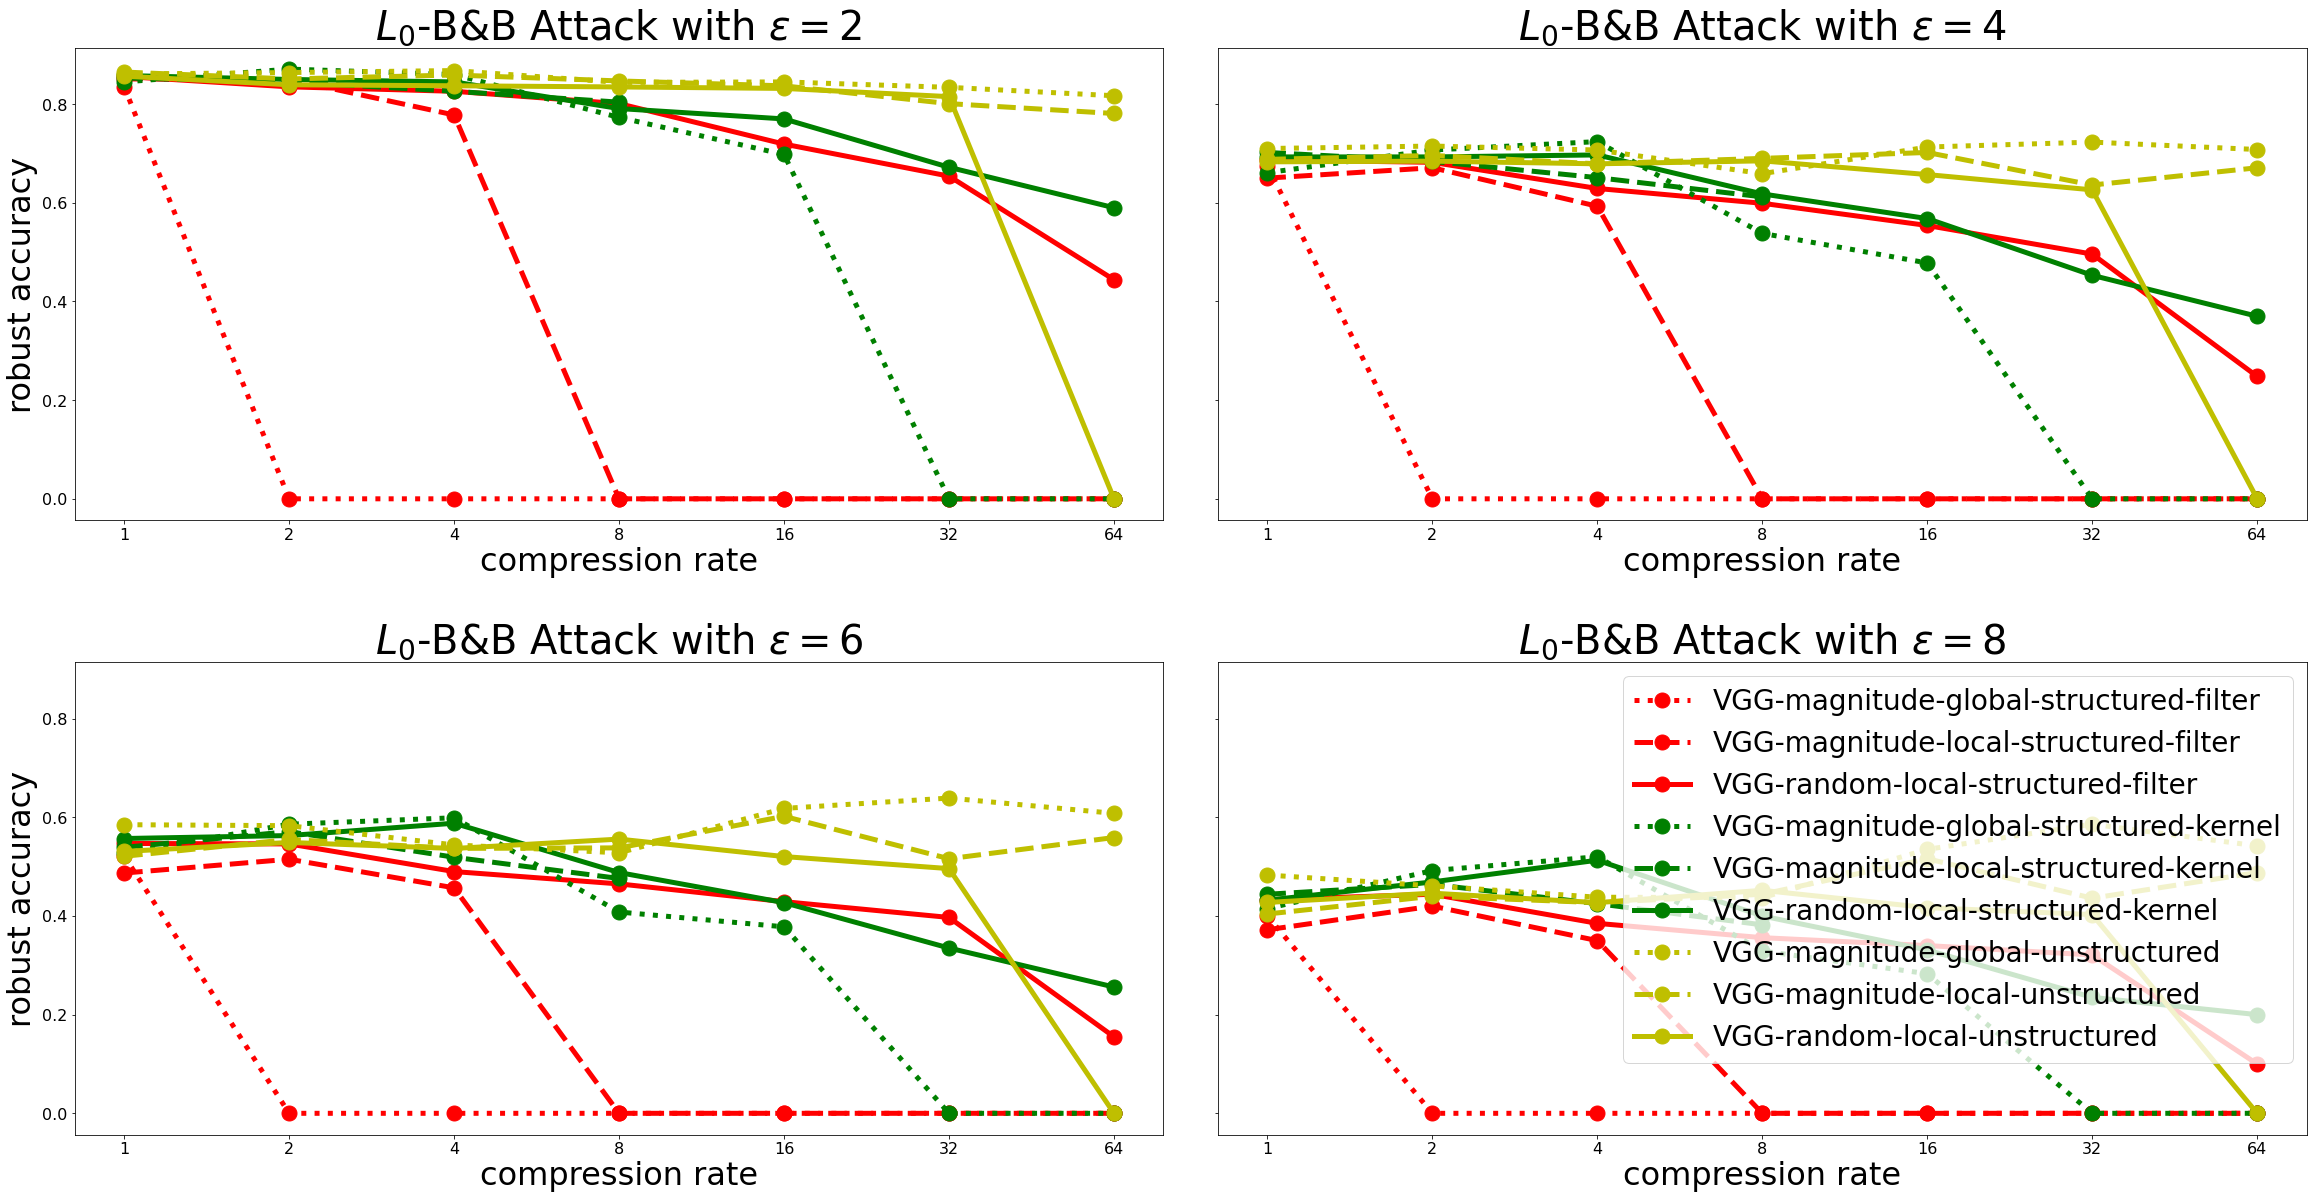

In [342]:
plot_graphic(
VGG_l0_fixed_eps_dfs, 
    title=r'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='VGG_l0_fixed_eps'
)
#cnn_l0_fixed_eps_df

## $L_2$-Attack

In [343]:
local_eps= [2,2.5,3,3.5]
VGG_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='VGG', l2_eps=eps) for eps in local_eps]
#resnet_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='ResNet')

loading results
loading results
loading results
loading results


In [344]:
for i,df in enumerate(VGG_l2_fixed_eps_dfs):
    VGG_l2_fixed_eps_dfs[i] = df[['VGG-magnitude-global-structured-filter', 'VGG-magnitude-local-structured-filter', 
            'VGG-random-local-structured-filter', 'VGG-magnitude-global-structured-kernel', 
            'VGG-magnitude-local-structured-kernel', 'VGG-random-local-structured-kernel', 
            'VGG-magnitude-global-unstructured', 'VGG-magnitude-local-unstructured', 'VGG-random-local-unstructured']]

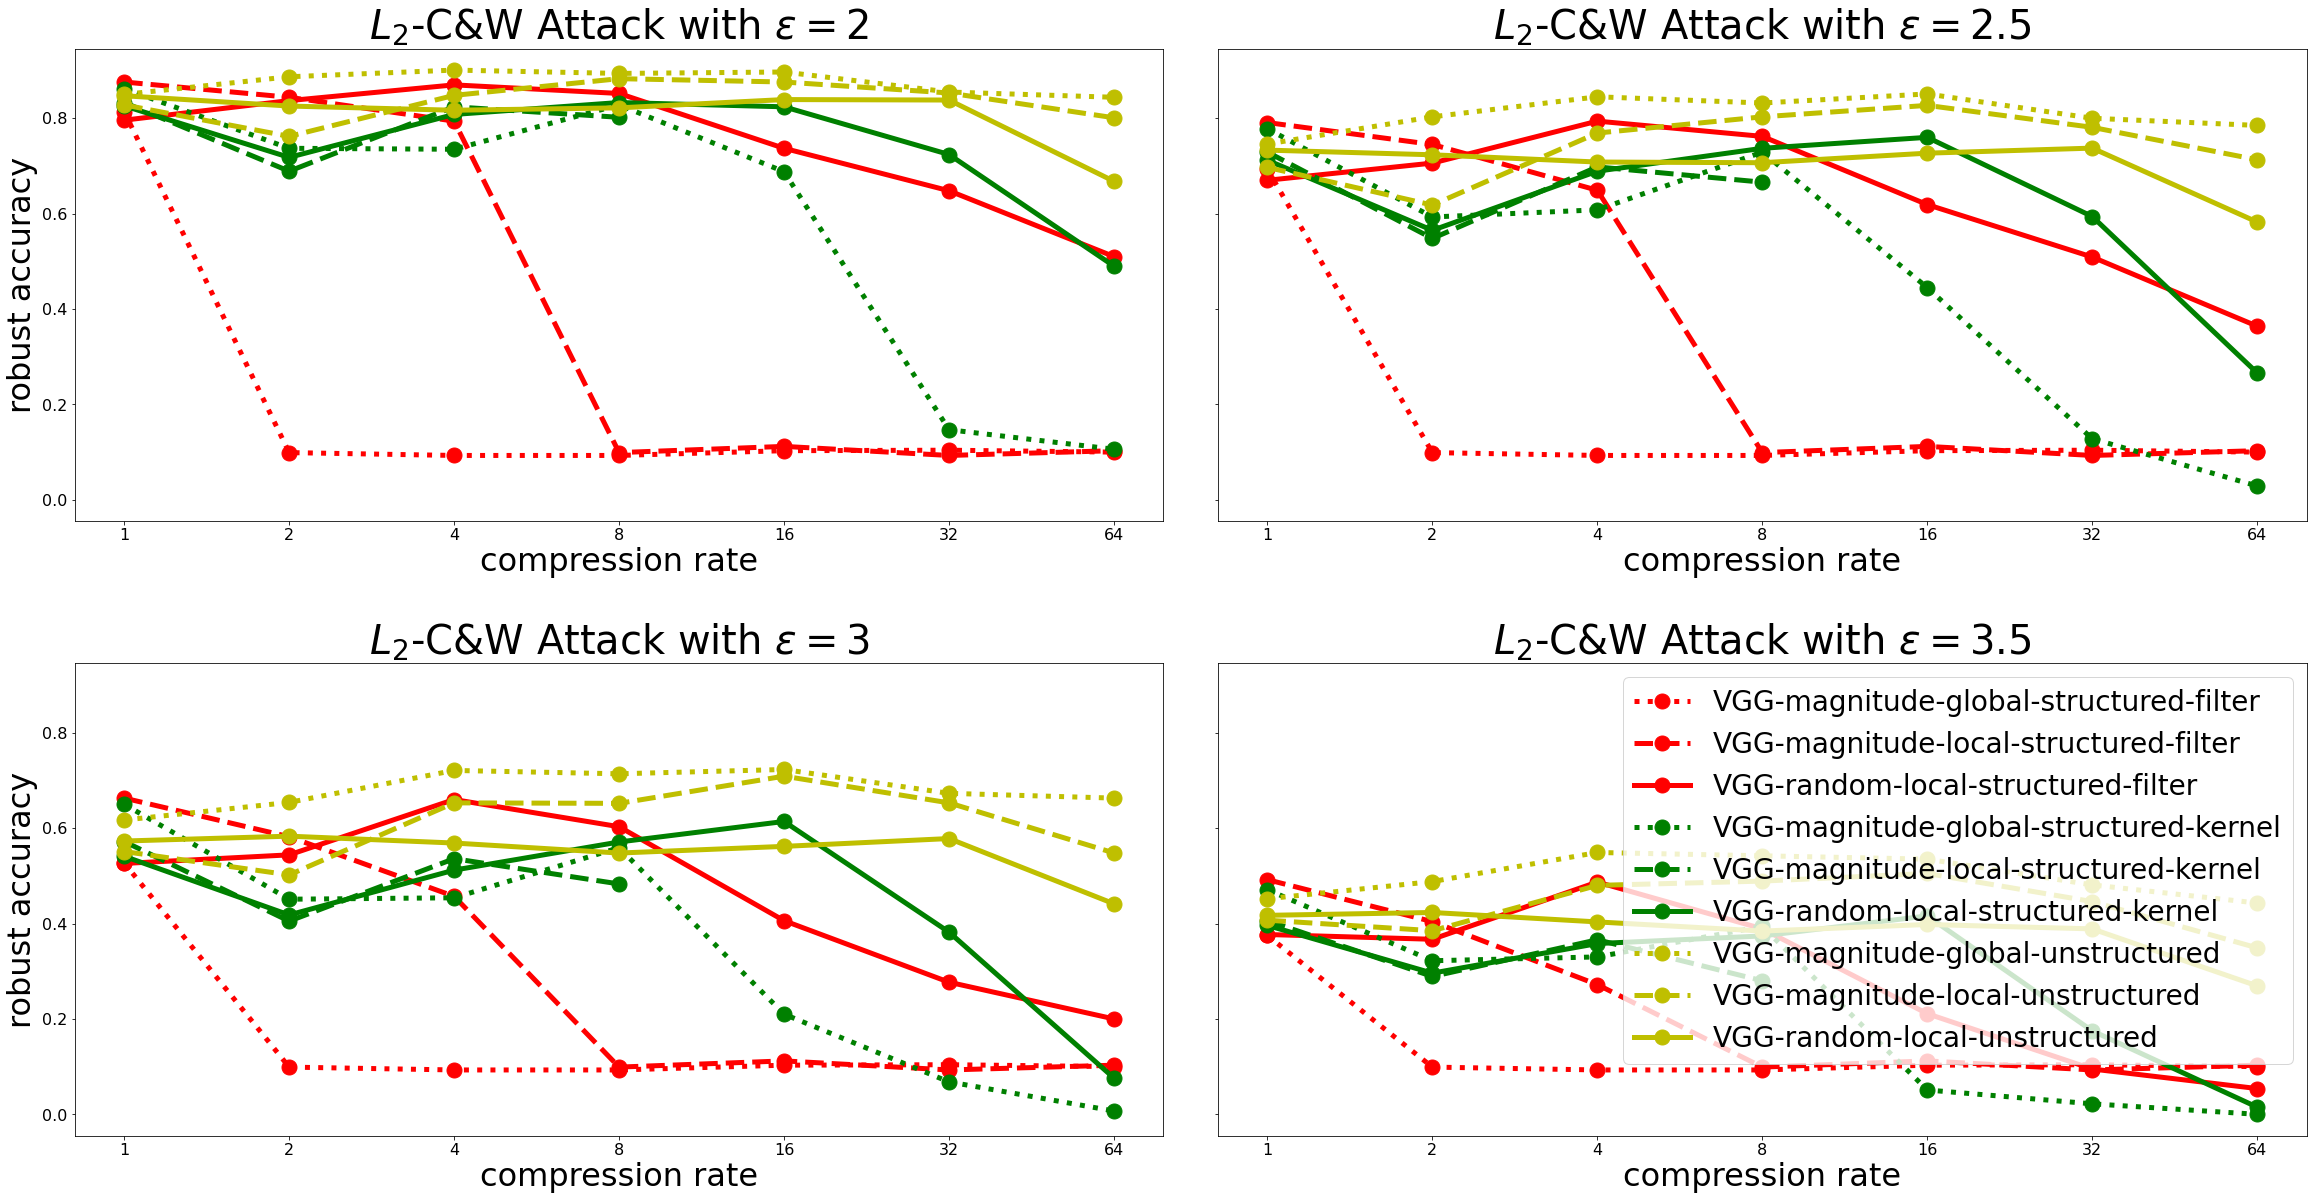

In [345]:
plot_graphic(
    VGG_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='VGG_l2_fixed_eps'
)
#cnn_l2_fixed_eps_df

## $L_\infty$-Attack

In [346]:
local_eps=[2,4,8,16]
VGG_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='VGG', l_inf_eps=eps) for eps in local_eps]
#resnet_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

loading results
loading results
loading results
loading results


In [347]:
for i,df in enumerate(VGG_l_inf_fixed_eps_dfs):

    VGG_l_inf_fixed_eps_dfs[i] = df[['VGG-magnitude-global-structured-filter', 'VGG-magnitude-local-structured-filter', 
            'VGG-random-local-structured-filter', 'VGG-magnitude-global-structured-kernel', 
            'VGG-magnitude-local-structured-kernel', 'VGG-random-local-structured-kernel', 
            'VGG-magnitude-global-unstructured', 'VGG-magnitude-local-unstructured', 
            'VGG-random-local-unstructured']]

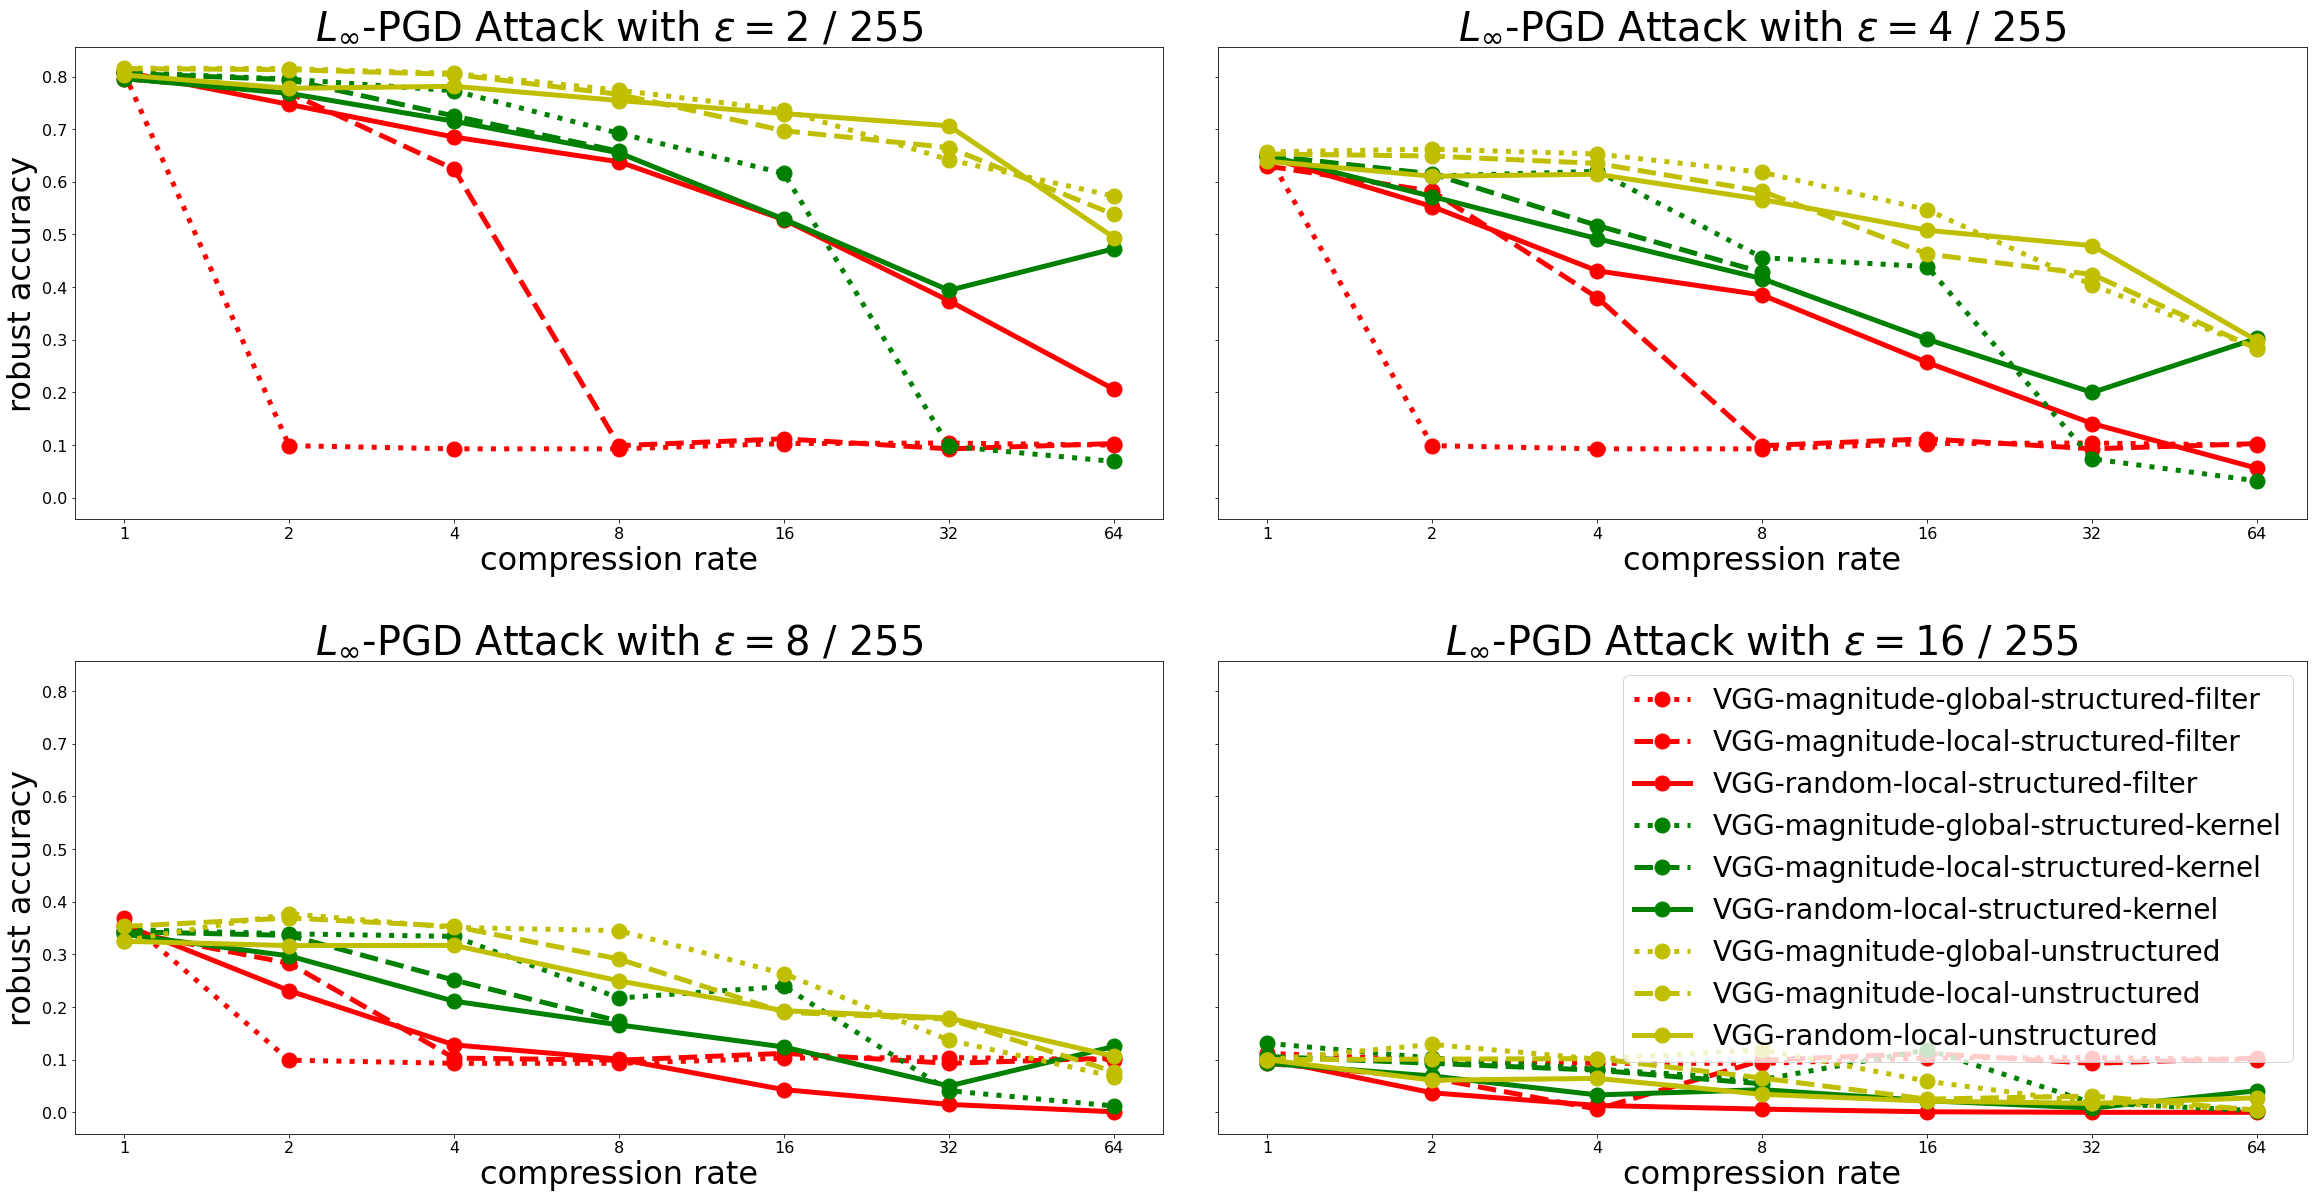

In [348]:
plot_graphic(
    VGG_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='VGG_l_inf_fixed_eps',
    infty=True
)

# ResNet18

## $L_0$-Attack

In [349]:
local_eps=[20,70,120,170]
resnet_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='ResNet', l0_eps=eps) for eps in local_eps]
#resnet_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

for i,df in enumerate(resnet_l0_fixed_eps_dfs):
    resnet_l0_fixed_eps_dfs[i] = df[['ResNet-magnitude-global-structured-filter', 'ResNet-magnitude-local-structured-filter', 
            'ResNet-random-local-structured-filter', 'ResNet-magnitude-global-structured-kernel', 
            'ResNet-magnitude-local-structured-kernel', 'ResNet-random-local-structured-kernel', 
            'ResNet-magnitude-global-unstructured', 'ResNet-magnitude-local-unstructured', 
            'ResNet-random-local-unstructured']]

loading results
loading results
loading results
loading results


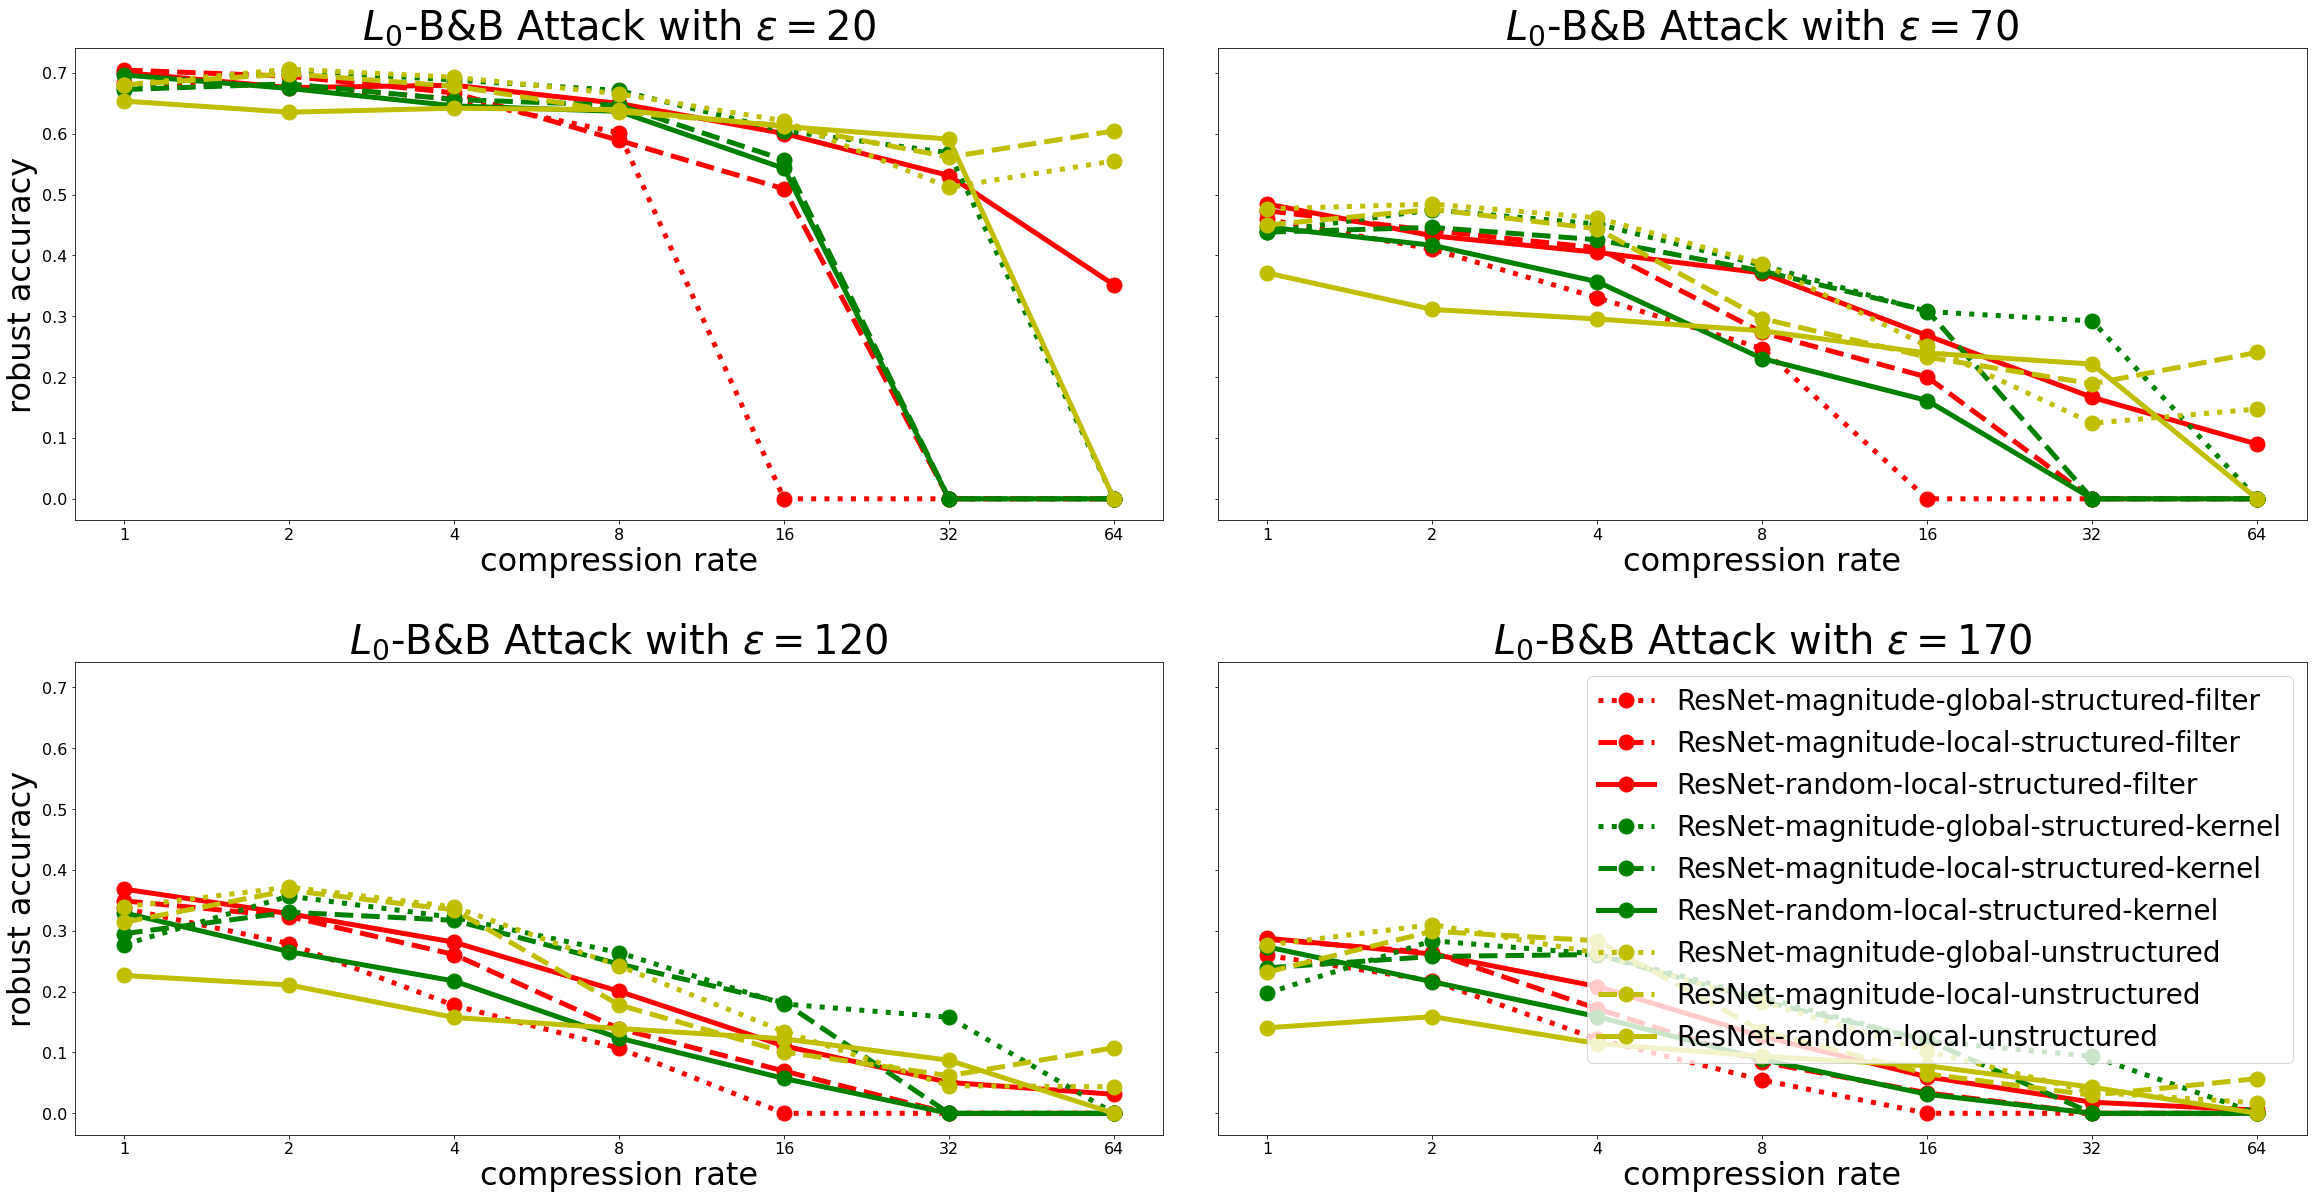

In [350]:
plot_graphic(
    resnet_l0_fixed_eps_dfs, 
    title=r'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet_l0_fixed_eps'
)
#cnn_l0_fixed_eps_df

## $L_2$-Attack

In [351]:
local_eps= [10,15,20,25]
resnet_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='ResNet', l2_eps=eps) for eps in local_eps]
#resnet_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='ResNet')

for i,df in enumerate(resnet_l2_fixed_eps_dfs):
    resnet_l2_fixed_eps_dfs[i] = df[['ResNet-magnitude-global-structured-filter', 'ResNet-magnitude-local-structured-filter', 
            'ResNet-random-local-structured-filter', 'ResNet-magnitude-global-structured-kernel', 
            'ResNet-magnitude-local-structured-kernel', 'ResNet-random-local-structured-kernel', 
            'ResNet-magnitude-global-unstructured', 'ResNet-magnitude-local-unstructured', 
            'ResNet-random-local-unstructured']]

loading results
loading results
loading results
loading results


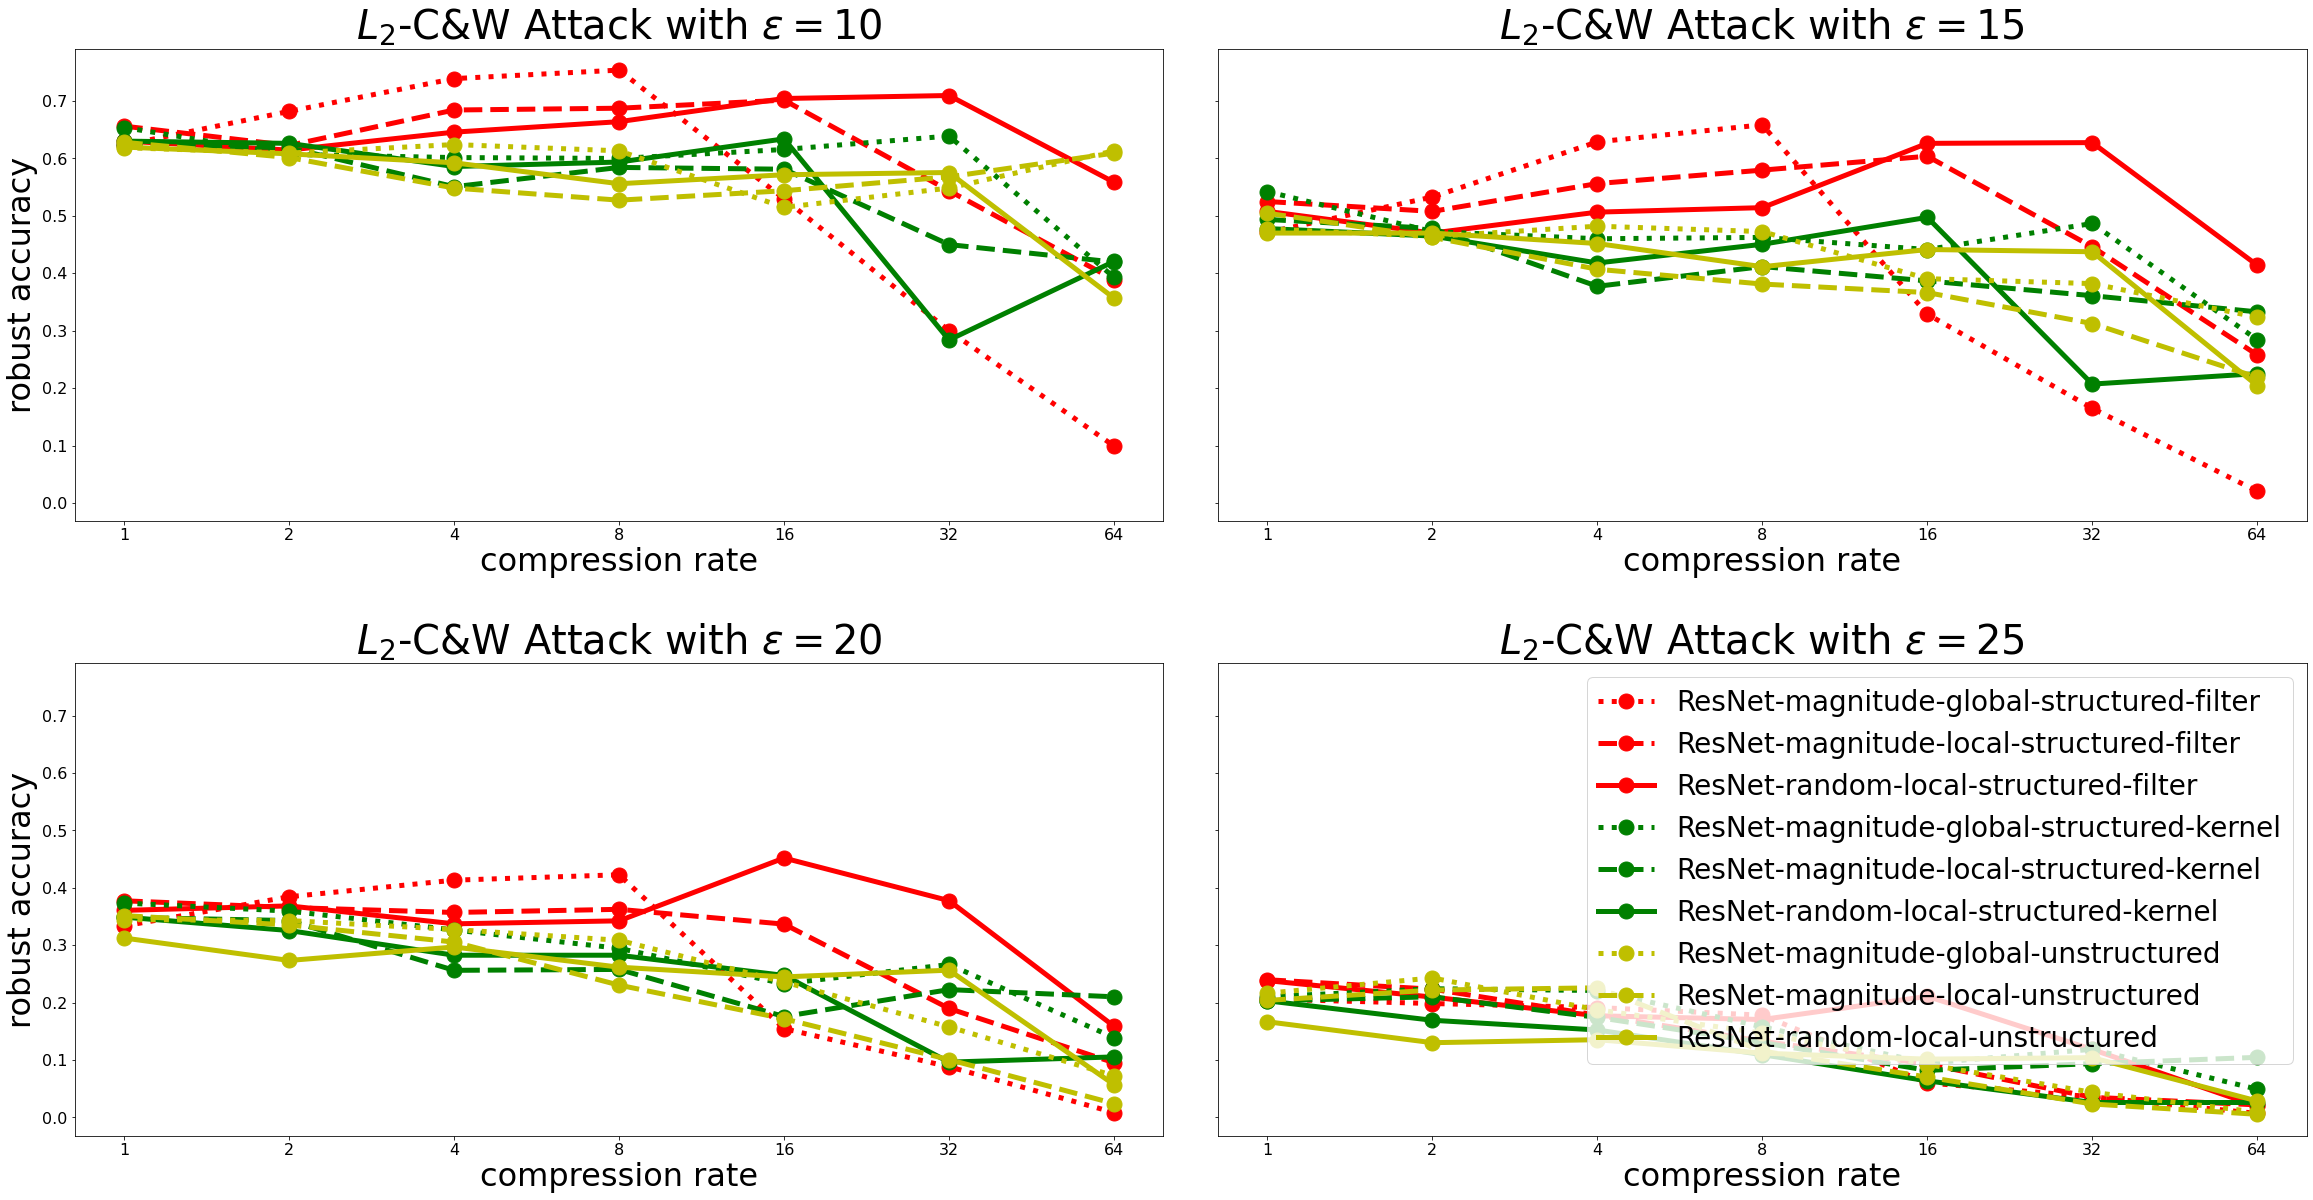

In [352]:
plot_graphic(
    resnet_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet_l2_fixed_eps'
)
#cnn_l2_fixed_eps_df

## $L_\infty$-Attack

In [353]:
local_eps=[.5,1,2,4]
resnet_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='ResNet', l_inf_eps=eps) for eps in local_eps]
#resnet_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')
for i,df in enumerate(resnet_l_inf_fixed_eps_dfs):

    resnet_l_inf_fixed_eps_dfs[i] = df[['ResNet-magnitude-global-structured-filter', 'ResNet-magnitude-local-structured-filter', 
            'ResNet-random-local-structured-filter', 'ResNet-magnitude-global-structured-kernel', 
            'ResNet-magnitude-local-structured-kernel', 'ResNet-random-local-structured-kernel', 
            'ResNet-magnitude-global-unstructured', 'ResNet-magnitude-local-unstructured', 
            'ResNet-random-local-unstructured']]

loading results
loading results
loading results
loading results


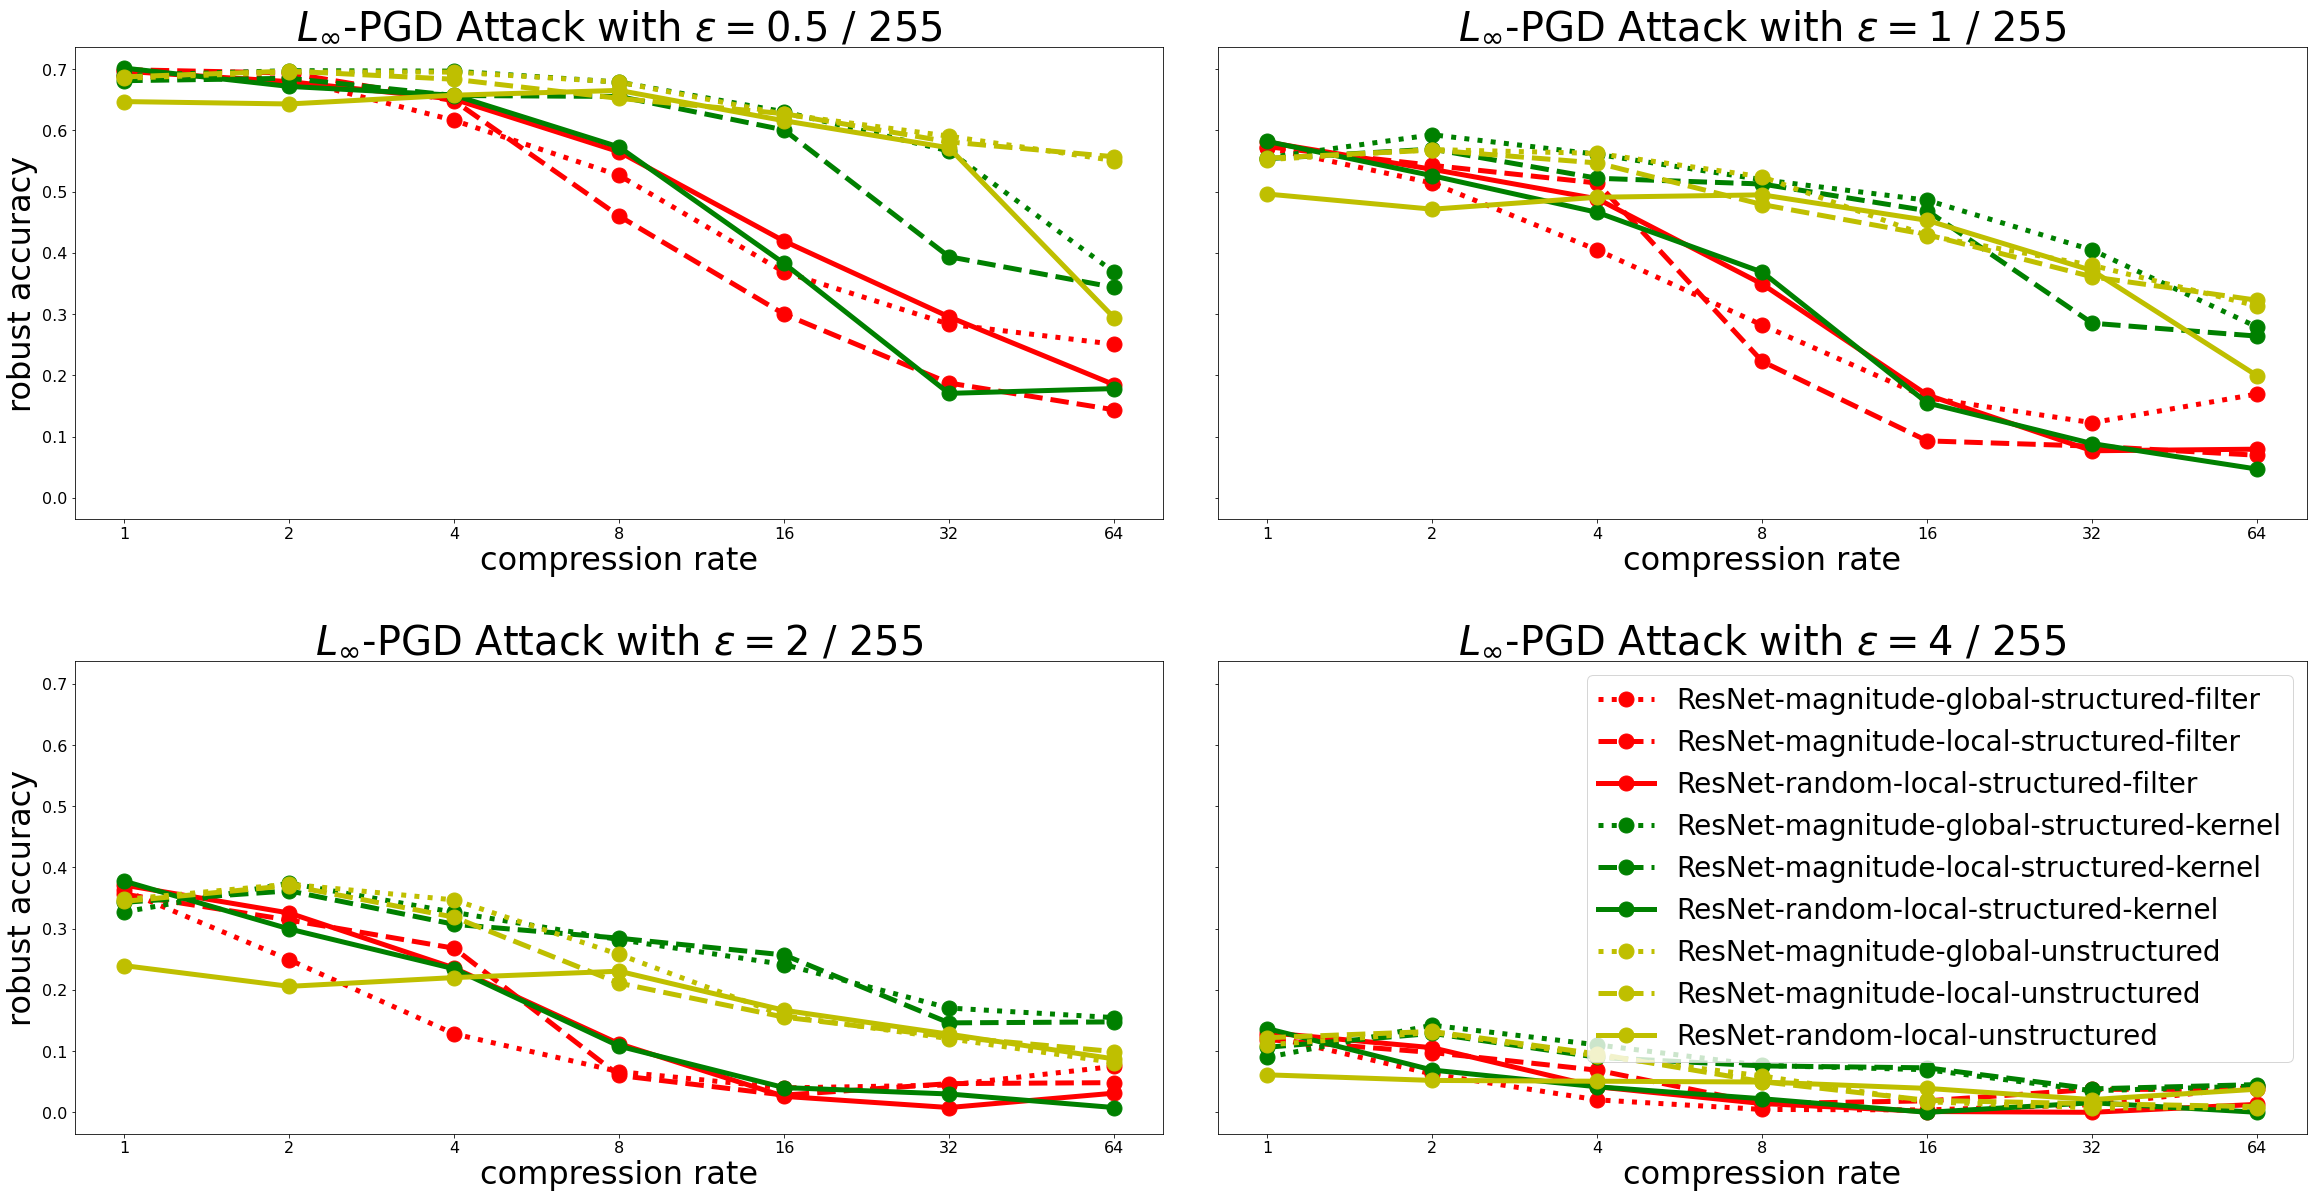

In [354]:
plot_graphic(
    resnet_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet_l_inf_fixed_eps',
    infty=True
)

In [ ]:
all_dfs = [

    resnet_l_inf_fixed_eps_dfs,
    resnet_l0_fixed_eps_dfs,
    resnet_l2_fixed_eps_dfs
]

for df in all_dfs:
    test = [calc_diffs_from_first_row(x) for x in df]
    for x in test:
        print(x.max())
        print(x.idxmax())

# Average change in robustness over attacks and $\epsilon$ values per architecture and pruning method

In [ ]:
def calc_mean_unpruned_vals(dfs):
    for i in range(len(dfs)):
        mean = dfs[i].iloc[0].mean()
        for j in range(len(dfs[i].iloc[0])):
            dfs[i].iloc[0][j] = mean
    return dfs


In [ ]:
def calc_diffs_from_first_row(df):
    return df.sub(df.iloc[0], axis=1)

def sum_up_and_average_df_element_wise(dfs):
    avg_df = dfs[0]
    for i in range(1, len(dfs)):
        avg_df = avg_df + dfs[i]
    #print(len(dfs))
    return avg_df/len(dfs)

In [ ]:
mag_loc_struct = pd.DataFrame()
mag_glob_unstruct = pd.DataFrame()

In [ ]:
resnet_dfs = resnet_l0_fixed_eps_dfs+resnet_l2_fixed_eps_dfs+resnet_l_inf_fixed_eps_dfs
resnet_diffs = [calc_diffs_from_first_row(resnet_dfs[i]) for i in range(len(resnet_dfs))]
res_df = sum_up_and_average_df_element_wise(resnet_diffs)
(res_df).round(4)
mag_loc_struct['ResNet'] = (res_df).round(4)['ResNet-magnitude-local-structured-kernel']
mag_glob_unstruct['ResNet'] = (res_df).round(4)['ResNet-magnitude-global-unstructured']

In [ ]:
cnn_s_dfs = cnn_l0_fixed_eps_dfs+cnn_l2_fixed_eps_dfs+cnn_l_inf_fixed_eps_dfs
cnn_s_diffs = [calc_diffs_from_first_row(cnn_s_dfs[i]) for i in range(len(cnn_s_dfs))]
cnn_df = sum_up_and_average_df_element_wise(cnn_s_diffs)
(cnn_df).round(4)
mag_loc_struct['CNN'] = (cnn_df).round(4)['cnn-magnitude-local-structured-kernel']
mag_glob_unstruct['CNN'] = (cnn_df).round(4)['cnn-magnitude-global-unstructured']

In [ ]:
mlp_dfs = mlp_l0_fixed_eps_dfs+mlp_l2_fixed_eps_dfs+mlp_l_inf_fixed_eps_dfs
mlp_diffs = [calc_diffs_from_first_row(mlp_dfs[i]) for i in range(len(mlp_dfs))]
mlp_df = sum_up_and_average_df_element_wise(mlp_diffs)
(mlp_df).round(4)
mag_loc_struct['MLP'] = (mlp_df).round(4)['MLP-magnitude-local-structured']
mag_glob_unstruct['MLP'] = (mlp_df).round(4)['MLP-magnitude-global-unstructured']

In [ ]:
mag_loc_struct

In [ ]:
mag_glob_unstruct

In [ ]:
pd.concat([mag_loc_struct, mag_glob_unstruct], axis=1)

In [114]:
def get_clean_accs_df(architecture='ResNet'):
    all_clean_accs = {}
    if architecture=='ResNet8':
        method_keys = keys[18:27]
    if architecture=='ResNet':
        method_keys = keys[9:18]
    if architecture=='VGG':
        method_keys = keys[27:]
    #if architecture=='MLP':
    #    keys = list(res.keys())[9:18]
    if architecture=='CNN':
        method_keys = keys[:9]
        
    for key in method_keys:
        method_results = res[key]

        ratios = method_results['pruning_ratio'].unique()
        avg_clean_acc = {}
        for ratio in ratios:
            frac_ratio = 1/(1-ratio)
            a = method_results.loc[method_results['pruning_ratio'] == ratio]
            avg_clean_acc[frac_ratio] = a['accuracy'].mean()
        all_clean_accs[key] = pd.Series(avg_clean_acc, )#index=[0])
    return pd.concat(all_clean_accs, axis=1, sort=False)

In [ ]:
def plot_clean_accuracy(clean_acc_df, x_axis_label = 'compression ratio', y_axis_label = 'accuracy', title='Clean Accuracies', figname='unnamed.png'):


    fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.3})
    #axes = axes.flatten()

    x = clean_acc_df.plot(marker='o', markersize=15,figsize=(40,10), fontsize=16, linewidth=5,ax=ax)
    x.set_title(title, fontsize=40)
    x.set_xscale('log')
    x.set_xticks([1,2,4,8,16,32,64])
    x.set_xticklabels([1,2,4,8,16,32,64] )
    x.minorticks_off()
    x.set_xlabel(x_axis_label, fontsize=32)
    x.set_ylabel(y_axis_label, fontsize=32)

    x.legend(loc=3,prop={'size': 28})

        #fig.tight_layout()
    fig.savefig(f'./graphics/{figname}.png', dpi=72, bbox_inches='tight')

# Clean Accuracy - MLP

In [ ]:
MLP_clean_accs = get_clean_accs_df(architecture='MLP')
plot_clean_accuracy(MLP_clean_accs, figname='MLP-clean-accs', title='MLP')
MLP_clean_accs

# Clean Accuracy - CNN$_s$

In [ ]:
CNN_clean_accs = get_clean_accs_df(architecture='CNN')
plot_clean_accuracy(CNN_clean_accs, figname='CNN-clean-accs', title='CNN')
CNN_clean_accs

# Clean Accuracy - CNN $_L$

In [ ]:
ResNet_clean_accs = get_clean_accs_df(architecture='ResNet')
plot_clean_accuracy(ResNet_clean_accs, figname='ResNet-clean-accs', title='ResNet')
ResNet_clean_accs

# Vary attack

In [ ]:
resnet = pd.DataFrame()
resnet[r'$L_0$'] = resnet_l0_fixed_eps_dfs[1]['ResNet-magnitude-global-unstructured']
resnet[r'$L_2$'] = resnet_l2_fixed_eps_dfs[1]['ResNet-magnitude-global-unstructured']
resnet[r'$L_\infty$'] = resnet_l_inf_fixed_eps_dfs[1]['ResNet-magnitude-global-unstructured']

In [ ]:
cnn = pd.DataFrame()
cnn[r'L_0'] = cnn_l0_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
cnn[r'L_2'] = cnn_l2_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
cnn[r'L_\infty'] = cnn_l_inf_fixed_eps_dfs[3]['cnn-magnitude-global-unstructured']

In [ ]:
mlp = pd.DataFrame()
mlp[r'L_0'] = mlp_l0_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
mlp[r'L_2'] = mlp_l2_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
mlp[r'L_\infty'] = mlp_l_inf_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']

In [ ]:
x_axis_label = 'compression rate'
y_axis_label = 'robust accuracy'
        
fig, axes = plt.subplots(ncols=1, nrows=3, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.5})
#axes = axes.flatten()
    

x = resnet.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[0])
x.set_title('Resnet', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

x = cnn.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[1])
x.set_title('CNN', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)


x = mlp.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[2])
x.set_title('MLP', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)
#fig.savefig(f'./graphics/{figname}.png', dpi=72, bbox_inches='tight')

In [ ]:
test = [cnn_l0_fixed_eps_dfs[1],
cnn_l2_fixed_eps_dfs[1],
cnn_l_inf_fixed_eps_dfs[1]]

In [ ]:
l0 = pd.DataFrame()
l0[r'MLP'] = mlp_l0_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
l0[r'CNN'] = cnn_l0_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
l0[r'ResNet'] = resnet_l0_fixed_eps_dfs[2]['ResNet-magnitude-global-unstructured']# Vary architecture

In [ ]:
l2 = pd.DataFrame()
l2[r'MLP'] = mlp_l2_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
l2[r'CNN'] = cnn_l2_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
l2[r'ResNet'] = resnet_l2_fixed_eps_dfs[2]['ResNet-magnitude-global-unstructured']# Vary architecture

In [ ]:
l_inf = pd.DataFrame()
l_inf[r'MLP'] = mlp_l_inf_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
l_inf[r'CNN'] = cnn_l_inf_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
l_inf[r'ResNet'] = resnet_l_inf_fixed_eps_dfs[2]['ResNet-magnitude-global-unstructured']# Vary architecture

In [ ]:
l2

In [ ]:
x_axis_label = 'compression rate'
y_axis_label = 'robust accuracy'
        
fig, axes = plt.subplots(ncols=1, nrows=3, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.5})
#axes = axes.flatten()
    

x = l0.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[0])
x.set_title('L0', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

x = l2.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[1])
x.set_title('L2', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)


x = l_inf.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[2])
x.set_title('L inf', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

In [ ]:
plot_graphic(
    [resnet_l2_fixed_eps_dfs[0], resnet_l2_fixed_eps_dfs[2], resnet_l2_fixed_eps_dfs[0], resnet_l2_fixed_eps_dfs[2]], 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='pruning ratio',
    y_axis_label='robust accuracy',
    eps=[10,20,10,20],
    figname='resnet_variance'
)
#cnn_l2_fixed_eps_df

In [ ]:
test = pd.DataFrame()

In [ ]:
test[r'$B&B-L_0$ attack with $\epsilon = 30$'] = resnet_l0_fixed_eps_dfs[1]['ResNet-magnitude-local-structured']
test[r'$C&W-L_2$ attack with $\epsilon = 15$'] = resnet_l2_fixed_eps_dfs[1]['ResNet-magnitude-local-structured']
test[r'$PGD-L_\infty$ attack with $\epsilon = 1 / 255$'] = resnet_l_inf_fixed_eps_dfs[1]['ResNet-magnitude-local-structured']

In [ ]:
test

In [ ]:
x_axis_label = 'compression rate'
y_axis_label = 'robust accuracy'
        
fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.5})
#axes = axes.flatten()
    

x = test.plot(marker='o', markersize=15,figsize=(40,8), fontsize=16, linewidth=5, ax=axes)

x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

x.legend(prop={'size': 28})
fig.savefig(f'./graphics/attack-metric.png', dpi=72, bbox_inches='tight')

In [ ]:
import pickle
advs = 0
with (open('advs', "rb")) as openfile:
    advs = pickle.load(openfile)
advs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(img, alpha=0.25)

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,20) , gridspec_kw={'wspace': 0.05, 'hspace':.5})
axes = axes.flatten()

axes
axes[0].imshow(advs['l0']['original'])
axes[0].set_xlabel("Parachute", fontsize=38)
axes[0].set_ylabel(r"B&B $L_0$", fontsize=38)
axes[1].imshow(0.5+advs['l0']['perturbation'])
axes[1].set_xlabel(r"1$\times$", fontsize=38)
axes[2].imshow(advs['l0']['adversarial'])
axes[2].set_xlabel(r"church", fontsize=38)

axes[3].imshow(advs['l2']['original'])
axes[3].set_xlabel("Parachute", fontsize=38)
axes[3].set_ylabel(r"C&W $L_2$", fontsize=38)
axes[4].imshow(0.5+10*advs['l2']['perturbation'])
axes[4].set_xlabel(r"10$\times$", fontsize=38)
axes[5].imshow(advs['l2']['adversarial'])
axes[5].set_xlabel(r"Golf ball", fontsize=38)


axes[6].imshow(advs['linf']['original'])
axes[6].set_ylabel(r"PGD $L_\infty$", fontsize=38)
axes[6].set_xlabel("Parachute", fontsize=38)
axes[7].imshow(0.5+10*advs['linf']['perturbation'])
axes[7].set_xlabel(r"10$\times$", fontsize=38)
axes[8].imshow(advs['linf']['adversarial'])
axes[8].set_xlabel(r"Golf ball", fontsize=38)

for ax in axes:
    ax.set_xticks([], [])  # note you need two lists one for the positions and one for the labels
    ax.set_yticks([], [])  # same for y ticks



In [ ]:
axes

In [ ]:
x = l2.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[1])
x.set_title('L2', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)


x = l_inf.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[2])
x.set_title('L inf', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

In [295]:
keys

['CNN-magnitude-global-structured-filter',
 'CNN-magnitude-global-structured-kernel',
 'CNN-magnitude-global-unstructured',
 'CNN-magnitude-local-structured-filter',
 'CNN-magnitude-local-structured-kernel',
 'CNN-magnitude-local-unstructured',
 'CNN-random-local-structured-filter',
 'CNN-random-local-structured-kernel',
 'CNN-random-local-unstructured',
 'ResNet-magnitude-global-structured-filter',
 'ResNet-magnitude-global-structured-kernel',
 'ResNet-magnitude-global-unstructured',
 'ResNet-magnitude-local-structured-filter',
 'ResNet-magnitude-local-structured-kernel',
 'ResNet-magnitude-local-unstructured',
 'ResNet-random-local-structured-filter',
 'ResNet-random-local-structured-kernel',
 'ResNet-random-local-unstructured',
 'ResNet8-magnitude-global-structured-filter',
 'ResNet8-magnitude-global-structured-kernel',
 'ResNet8-magnitude-global-unstructured',
 'ResNet8-magnitude-local-structured-filter',
 'ResNet8-magnitude-local-structured-kernel',
 'ResNet8-magnitude-local-unstr

# graph interpolation

In [355]:
def interpolate_graph(attack_type, architecture, experiment_name, eps):
    l2_eps = 0
    l0_eps = 0
    l_inf_eps = 4
    if attack_type == 'l2': l2_eps = eps
    if attack_type == 'l0': l0_eps = eps
    if attack_type == 'l_inf': l_inf_eps = eps
    adv_accs = create_fixed_eps_dataframe(attack_type=attack_type, architecture=architecture,)
    a = adv_accs[experiment_name].rename('1')
    clean_accs = get_clean_accs_df(architecture=architecture)
    b = clean_accs[experiment_name].rename('0')
    c = pd.concat([a, b], axis=1)
    c = c[['0', '1']].T
    plot = c.plot()
    plot.set_ylabel('Test Accuracy')
    plot.set_xlabel('Ratio of Attackers')
    plot.set_title(f'{experiment_name} - {attack_type}-attack - eps = {eps}')
    return plot

loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results


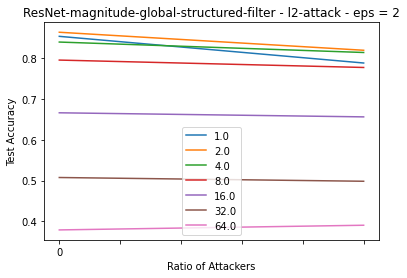

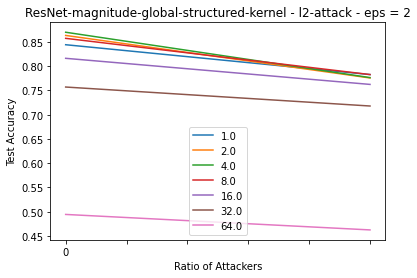

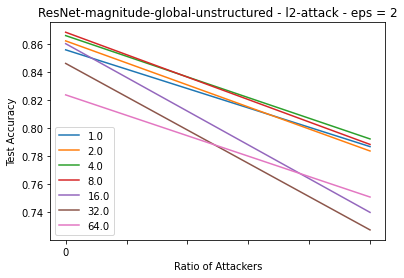

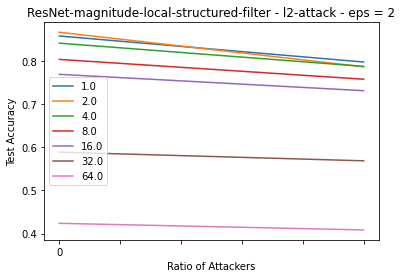

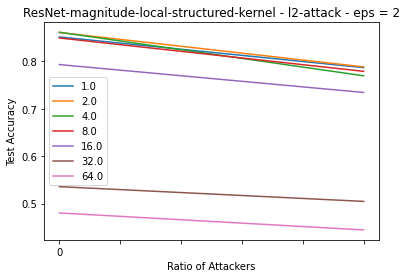

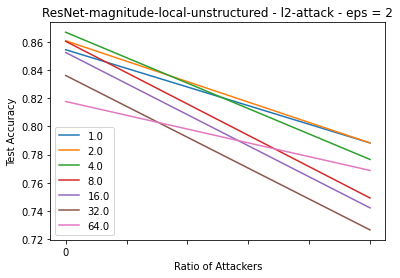

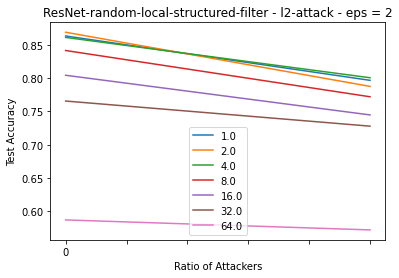

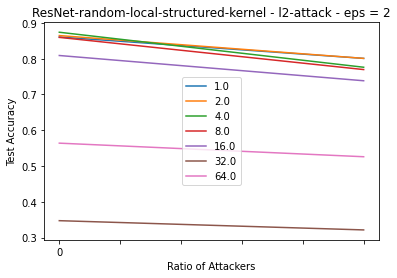

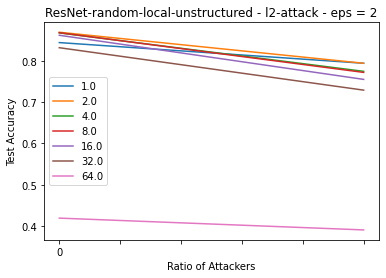

In [356]:
for experiment_name in keys[9:18]:
    attack_type='l2'
    architecture= experiment_name.split('-')[0]
    #experiment_name = 'ResNet-magnitude-global-structured-filter'
    eps = 2
    plot = interpolate_graph(attack_type, architecture, experiment_name, eps=eps)

In [161]:
a = resnet_l2_fixed_eps_dfs[0]['ResNet-magnitude-global-structured-filter'].rename('1')
a

1.0     0.623437
2.0     0.682031
4.0     0.739062
8.0     0.753906
16.0    0.529687
32.0    0.300000
64.0    0.099219
Name: 1, dtype: float64

In [162]:
ResNet_clean_accs = get_clean_accs_df(architecture='ResNet')
b = ResNet_clean_accs['ResNet-magnitude-global-structured-filter'].rename('0')
b

1.0     0.853656
2.0     0.863694
4.0     0.839643
8.0     0.795465
16.0    0.666242
32.0    0.507618
64.0    0.379159
Name: 0, dtype: float64

Text(0.5, 1.0, 'ResNet18 - global magnitude filter pruning - $L_2$-C&W - $\\epsilon = 10 $')

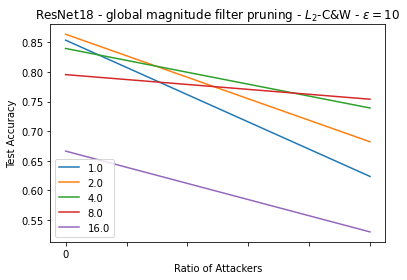

In [198]:
c = pd.concat([a, b], axis=1)[:16]

c = c[['0', '1']].T

plot = c.plot()
plot.set_ylabel('Test Accuracy')
plot.set_xlabel('Ratio of Attackers')
plot.set_title('ResNet18 - global magnitude filter pruning - $L_2$-C&W - $\epsilon = 10 $')

In [178]:
c[:4]

1.0       2.0       4.0       8.0       16.0      32.0      64.0
0  0.853656  0.863694  0.839643  0.795465  0.666242  0.507618  0.379159
1  0.623437  0.682031  0.739062  0.753906  0.529687  0.300000  0.099219

# Graph Interpolation 2

In [282]:
a = resnet_l2_fixed_eps_dfs[0].loc[8.0].rename('1')
a

ResNet-magnitude-global-structured-filter    0.753906
ResNet-magnitude-local-structured-filter     0.687500
ResNet-random-local-structured-filter        0.664062
ResNet-magnitude-global-structured-kernel    0.600000
ResNet-magnitude-local-structured-kernel     0.584375
ResNet-random-local-structured-kernel        0.593750
ResNet-magnitude-global-unstructured         0.613281
ResNet-magnitude-local-unstructured          0.527344
ResNet-random-local-unstructured             0.554688
Name: 1, dtype: float64

In [283]:
ResNet_clean_accs = get_clean_accs_df(architecture='ResNet')
b = ResNet_clean_accs.loc[8.0].rename('0')
b

ResNet-magnitude-global-structured-filter    0.795465
ResNet-magnitude-global-structured-kernel    0.857478
ResNet-magnitude-global-unstructured         0.868229
ResNet-magnitude-local-structured-filter     0.803771
ResNet-magnitude-local-structured-kernel     0.849274
ResNet-magnitude-local-unstructured          0.860382
ResNet-random-local-structured-filter        0.841783
ResNet-random-local-structured-kernel        0.859448
ResNet-random-local-unstructured             0.871083
Name: 0, dtype: float64

In [284]:
c = pd.concat([a, b], axis=1)
c = c[['0', '1']]
c = c.T

In [285]:

c = c[['ResNet-magnitude-global-structured-filter', 'ResNet-random-local-structured-filter', 'ResNet-magnitude-global-unstructured', 'ResNet-random-local-unstructured']]
c

ResNet-magnitude-global-structured-filter  \
0                                   0.795465   
1                                   0.753906   

   ResNet-random-local-structured-filter  \
0                               0.841783   
1                               0.664062   

   ResNet-magnitude-global-unstructured  ResNet-random-local-unstructured  
0                              0.868229                          0.871083  
1                              0.613281                          0.554688

Text(0.5, 1.0, 'ResNet18 - compression rate of 8 - $L_2$-C&W - $\\epsilon = 10 $')

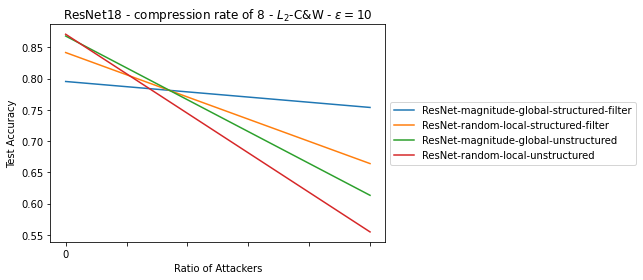

In [286]:
#c = c[['0', '1']].T

plot = c.plot()
plot.set_ylabel('Test Accuracy')
plot.set_xlabel('Ratio of Attackers')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plot.set_title('ResNet18 - compression rate of 8 - $L_2$-C&W - $\epsilon = 10 $')